In [18]:
## Function Calls
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.figsize": (5.5, 3.2),
    "figure.dpi": 100,
    "savefig.dpi": 120,
})
from scipy.linalg import toeplitz, cholesky, solve_toeplitz, inv
from scipy.stats import invgamma

from clr_fallback import *
from functions.fn_GPerror_mult import *

# Define the likelihood function
import importlib
import functions.fn_GPerror_mult  # Import the module

importlib.reload(functions.fn_GPerror_mult)  # Reload the module
from functions.fn_GPerror_mult import *  # Re-import updated functions

# load cumtrapz
from scipy.integrate import cumulative_trapezoid

import time
import sys
from pathlib import Path

MODULE_DIR = Path.cwd() / "section2.4.1"
if str(MODULE_DIR) not in sys.path:
    sys.path.append(str(MODULE_DIR))

from modeling import (
    compute_covariance,
    get_ell,
    jeffreys_prior_logpdf,
    log_acceptance_ratio,
    log_acceptance_ratio_ci,
    generate_random_warpings,
    simulate_dataset,
    simulate_dataset_sbc,
)
from validation import (
    compute_ls,
    compute_pc,
    compute_sls,
    _eval_cfg,
    save_results,
    load_results,
    sbc_run,
    coverage_run,
)
import inference
importlib.reload(inference)
from inference import run_alg3_chain, make_cache_key, load_cache, save_cache
from visualization import render_sensitivity_heatmaps, build_pinch_context, render_pinching_plots

import validation



In [19]:
## Data (loaded)
from pathlib import Path
import numpy as np

data_path = Path("section2.4.1") / "data_st.npz"
if not data_path.exists():
    raise FileNotFoundError(f"Missing data file: {data_path}. Run section2.4.1_st_data.ipynb first.")

data = np.load(data_path, allow_pickle=True)

t = data["t"]
y = data["y"]
ys = data["ys"] if "ys" in data.files else y.copy()

g_true = data["g_true"]
f_true = data["f_true"]
gamma0 = data["gamma0"]
a_true = data["a_true"]
c_true = data["c_true"]

sig_y0 = float(data["sig_y0"]) if "sig_y0" in data.files else 0.1
num_obs = int(data["num_obs"]) if "num_obs" in data.files else y.shape[0]
num_points = int(data["num_points"]) if "num_points" in data.files else t.shape[0]

print("Loaded data:", data_path)
print("sig_y0:", sig_y0, "num_obs:", num_obs, "num_points:", num_points)



Loaded data: section2.4.1/data_st.npz
sig_y0: 0.2 num_obs: 10 num_points: 200


In [20]:
## Options
foldername = 'section2_4_1_st_v3'
cache_tag = 'v3'
display_plots = True
K = 50000
dispFreq = 5000

s2y = float(sig_y0)/2
print(s2y**2)

# Update Options
update_ell = False
update_nu = False

## Initialization##

# from clr_fallback import Psi_batch


t = np.linspace(0, 1, num_points)
# s2y = 1e-2 * np.ones(num_obs)# initialize noise variance
# s2y = sig_y0/2

update_s2y = False

a = np.zeros((num_obs, 1))
c = np.ones((num_obs, 1))

a_hyper = {"mean": 0, "var": 0.1}
c_hyper = {"shape": 1e1, "scale": 1e-1}
u = np.log(c)
ui_prime = np.zeros(num_obs)


s2y_hyper = {"shape": 1e-4, "scale": 1e-4}  # Inverse-Gamma

f = a + c * np.zeros((num_obs, num_points))
g = np.zeros(num_points)

y = ys.copy()

### Hyperparameters for the Kq and Kq*
# Hierarchical Model for Covariance of q_i and qstar
cov_kernel_h = "exp"  # squared exponential kernel
cov_kernel_g = "se"

# nu_h = 1; ell_h = get_ell(0.999, num_points)  # initialize scale factor and length scale of Covariance Kh
# nu_g = 10; ell_g = 1e-3
######nu_h, ell_h = 5, 10
###### nu_g, ell_g = 1, 0.01

nu_h = 1
ell_h = 5

nu_g = 1
ell_g = 0.01

# nu_g, ell_g = 5, get_ell(0.999, num_points)
# nu_g, ell_g = 5, 1e-2
#     0.999, num_points
# )  # initialize scale factor and length scale of Covariance Kq*

# nu_h = 500; ell_h = 100 # initialize hyperparameters of Kh
Kg, Lg = compute_covariance(t, nu_g, ell_g, cov_kernel_g)  
Kh, Lh = compute_covariance(t, nu_h, ell_h, cov_kernel_h)  

### time-warping hi and gamma_i (No info)
hInv = np.zeros((num_obs, num_points))
hInv_mean = np.zeros(num_points)
# use tile to create a 2D array: each row is a copy of t
gamma_hInv = np.tile(t, (num_obs, 1))

max_h = np.ones(num_obs) * 0.3
# Beta grids (base, fixed)
beta_h_base = np.array([0.03, 0.05, 0.07, 0.10, 0.14, 0.20, 0.28, 0.35, 0.45], dtype=float)
beta_g_base = np.array([0.002, 0.003, 0.005, 0.01, 0.02, 0.035, 0.05, 0.07, 0.10], dtype=float)
beta_h_choices = beta_h_base.copy()
beta_g_choices = beta_g_base.copy()

# Robbins–Monro adaptation (warm-up only)
beta_adapt = True
beta_n_adapt = None  # set to burn later
beta_window = 100
beta_acc_target_h = 0.25
beta_acc_target_g = 0.25
beta_c_h = 0.15
beta_c_g = 0.15

beta_fixed = 0.35
beta_h_fixed_prob = 0.05
beta_g_fixed_prob = 0.0

def _sample_beta(local_arr, beta_fixed, p_fixed):
    if np.random.rand() < p_fixed:
        return beta_fixed
    return np.random.choice(local_arr)

beta_distribution_h = lambda: _sample_beta(beta_h_choices, beta_fixed, beta_h_fixed_prob)
beta_distribution_g = lambda: _sample_beta(beta_g_choices, beta_fixed, beta_g_fixed_prob)
beta_distribution_h = lambda: _sample_beta(beta_h_choices, beta_fixed, beta_h_fixed_prob)
beta_distribution_g = lambda: _sample_beta(beta_g_choices, beta_fixed, beta_g_fixed_prob)
beta_distribution_h = lambda: _sample_beta(beta_local, beta_fixed, beta_h_fixed_prob)
beta_distribution_g = lambda: _sample_beta(beta_local, beta_fixed, beta_g_fixed_prob)
# To avoid heavy computation of inverse of Kq and Kq*, we use Toplitz approximations.
# Precompute log-determinant of correlation matrices of qi and q*
# log_det_R_g = compute_log_det_R(ell=ell_g, t=t, cov_kernel_type=cov_kernel_g)



0.010000000000000002


In [21]:
## MCMC (Alg3 v2 - numba)
np.random.seed(2)
burn_iter = int(0.2 * K)
import time
start_time = time.time()


mcmc_out = run_alg3_chain(
    y_local=y,
    t=t,
    ell_h=ell_h,
    nu_h=nu_h,
    ell_g=ell_g,
    nu_g=nu_g,
    cov_kernel_h=cov_kernel_h,
    cov_kernel_g=cov_kernel_g,
    K=K,
    dispFreq=dispFreq,
    s2y=s2y,
    beta_h_choices=beta_h_choices,
    beta_g_choices=beta_g_choices,
    beta_adapt=beta_adapt,
    beta_n_adapt=beta_n_adapt,
    beta_window=beta_window,
    beta_acc_target_h=beta_acc_target_h,
    beta_acc_target_g=beta_acc_target_g,
    beta_c_h=beta_c_h,
    beta_c_g=beta_c_g,
    beta_fixed=beta_fixed,
    beta_h_fixed_prob=beta_h_fixed_prob,
    beta_g_fixed_prob=beta_g_fixed_prob,
    update_s2y=update_s2y,
    s2y_hyper=s2y_hyper,
    a_hyper=a_hyper,
    c_hyper=c_hyper,
    seed=2,
    burn=int(burn_iter),
    thin=1,
    collect_traces=True,
    display_plots=display_plots,
    g_true=g_true,
)
elapsed = time.time() - start_time
elapsed_sec = elapsed

GammaInv = mcmc_out["GammaInv"]
G = np.asarray(mcmc_out["G"])
C = np.asarray(mcmc_out["C"])
A = np.asarray(mcmc_out["A"])
F = mcmc_out["F"]
Alpha = np.asarray(mcmc_out.get("Alpha", []))

# Recover g_old for plotting (alpha-free template)
G_old = G
if Alpha.size and C.size and G.size:
    c_bar = np.mean(C, axis=1).reshape(-1, 1)
    c_bar = np.maximum(c_bar, 1e-12)
    alpha_vec = Alpha.reshape(-1, 1)
    if alpha_vec.shape[0] == G.shape[0] and c_bar.shape[0] == G.shape[0]:
        G_old = G + alpha_vec / c_bar

SSE = [np.sum((y - f_samp) ** 2) for f_samp in F]
LogLikihood = [-0.5 * sse / (s2y ** 2) for sse in SSE]
S2y = [s2y] * len(SSE)

Acc_hInv = mcmc_out["Acc_hInv"]
Acc_rate_hInv = mcmc_out["Acc_rate_hInv"]
Acc_g = mcmc_out["Acc_g"]
Acc_c = mcmc_out["Acc_c"]
Acc_a = mcmc_out["Acc_a"]
Beta_h = mcmc_out["Beta_h"]
Beta_g = mcmc_out["Beta_g"]

# Final acceptance rates (mean over iterations)
acc_h_final = float(np.mean(Acc_hInv)) if len(Acc_hInv) else float("nan")
acc_g_final = float(np.mean(Acc_g)) if len(Acc_g) else float("nan")
print(f"[MCMC] Final acc_h={acc_h_final:.3f}, acc_g={acc_g_final:.3f}")

# Final beta values (pCN step sizes)
beta_h_final = float(Beta_h[-1]) if len(Beta_h) else float("nan")
beta_g_final = float(Beta_g[-1]) if len(Beta_g) else float("nan")
print(f"[MCMC] Final beta_h={beta_h_final:.4g}, beta_g={beta_g_final:.4g}")
beta_h_adapted = mcmc_out.get('Beta_h_adapted')
beta_g_adapted = mcmc_out.get('Beta_g_adapted')
beta_shift_h = mcmc_out.get('Beta_shift_h')
beta_shift_g = mcmc_out.get('Beta_shift_g')
if beta_h_adapted is not None and len(beta_h_adapted):
    print('[MCMC] Beta_h shift:', beta_shift_h)
    print('[MCMC] Beta_h adapted grid:', beta_h_adapted)
if beta_g_adapted is not None and len(beta_g_adapted):
    print('[MCMC] Beta_g shift:', beta_shift_g)
    print('[MCMC] Beta_g adapted grid:', beta_g_adapted)
acc_h_mean = mcmc_out.get("Acc_h_mean")
acc_g_mean = mcmc_out.get("Acc_g_mean")
if acc_h_mean is None:
    acc_h_chain = np.asarray(mcmc_out.get("Acc_rate_hInv", []))
    acc_h_mean = float(np.mean(acc_h_chain)) if acc_h_chain.size > 0 else float("nan")
if acc_g_mean is None:
    acc_g_chain = np.asarray(mcmc_out.get("Acc_g", []))
    acc_g_mean = float(np.mean(acc_g_chain)) if acc_g_chain.size > 0 else float("nan")
print(f"[MCMC] Acc_h={acc_h_mean:.3f}, Acc_g={acc_g_mean:.3f}")

# MCMC 결과 g_mean vs g_true (use g_old for plotting)
if G_old.size == 0 or "g_true" not in globals():
    raise RuntimeError("G_old/g_true가 없습니다. MCMC 셀과 데이터 생성 셀을 먼저 실행하세요.")

burn = int(min(burn_iter, G_old.shape[0]))
g_chain = G_old[burn:] if G_old.shape[0] > burn else G_old
g_mean = np.mean(np.asarray(g_chain), axis=0)
g_ci_lower = np.percentile(np.asarray(g_chain), 2.5, axis=0)
g_ci_upper = np.percentile(np.asarray(g_chain), 97.5, axis=0)




============================== MCMC Hyperparameters ==============================
 > Data: Shape=(10, 200), Range=[0.00, 1.00]
 > MCMC Config: K=50000, Burn=10000, Thin=1, Seed=2
 > Noise: s2y=0.10000 (Fixed)
 > Kernel h: type=exp, ell_h=10.0000, nu_h=0.5000
 > Kernel g: type=se, ell_g=0.0200, nu_g=0.5000
 > Prior a: N(mean=0, var=0.1)
 > Prior c: Gamma(shape=10.0, scale=0.1)
 > No c/a: False
 > Beta sampling: random choices (RM adapt enabled)
 > Beta adapt: n_adapt=2000, window=100, target_h=0.25, target_g=0.25
[Alg3] Iter [50000/50000] | Elapsed: 65.4s
[Alg3 Numba] MCMC Done.
[MCMC] Final acc_h=0.185, acc_g=0.229
[MCMC] Final beta_h=0.6381, beta_g=0.009075
[MCMC] Beta_h shift: 2.35997065492294
[MCMC] Beta_h adapted grid: [0.31137259767903935, 0.4284113726926391, 0.510117109249114, 0.5946033753363348, 0.6677081198520531, 0.7348132506057292, 0.7870037788946396, 0.8157338668286345, 0.8429105598216272]
[MCMC] Beta_g shift: -0.4618821356453561
[MCMC] Beta_g adapted grid: [0.0018942339124

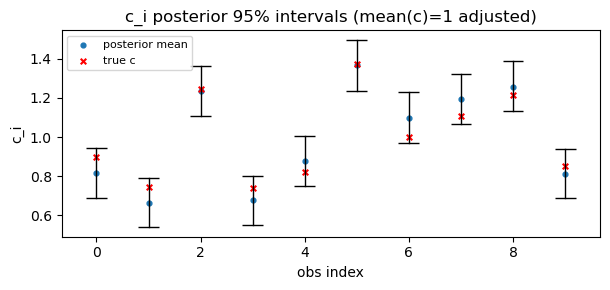

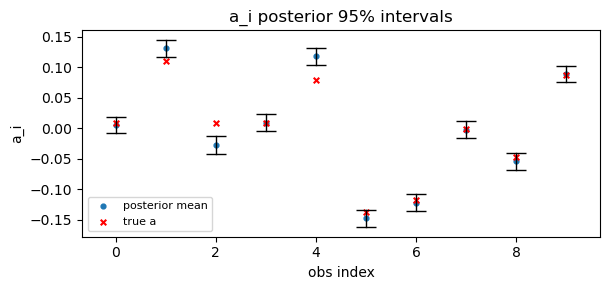

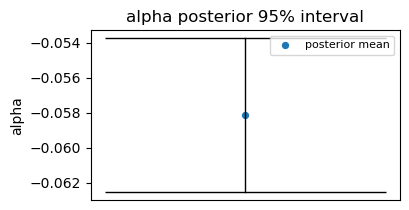

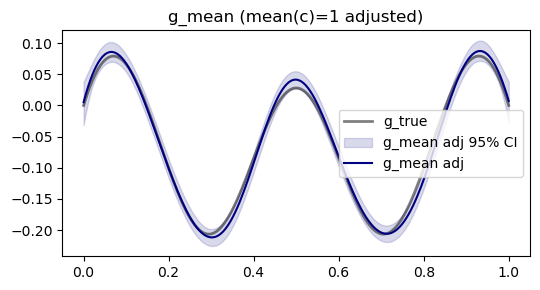

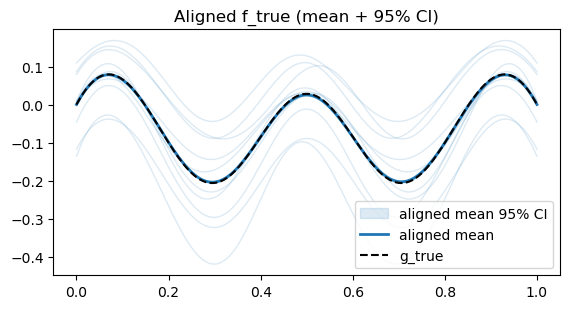

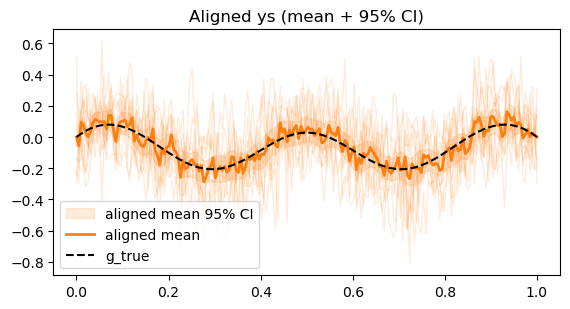

In [22]:
# --- Visualization (post-MCMC): c, a, alpha + aligned f/ys ---
import numpy as np
import matplotlib.pyplot as plt

if 'C' not in globals() or 'A' not in globals():
    raise RuntimeError('Missing C/A traces. Run MCMC cell first.')

burn = int(min(burn_iter, C.shape[0]))
C_chain = np.asarray(C)[burn:] if C.shape[0] > burn else np.asarray(C)
A_chain = np.asarray(A)[burn:] if A.shape[0] > burn else np.asarray(A)
Alpha_chain = np.asarray(Alpha)[burn:] if 'Alpha' in globals() and len(Alpha) > 0 else np.asarray([])
# arithmetic mean(c) per draw for adjustment
c_bar_arith = np.mean(C_chain[:, :, 0], axis=1) if C_chain.size else None
if c_bar_arith is not None:
    c_bar_arith = np.maximum(c_bar_arith, 1e-12)

# c_i, a_i posterior intervals with true values (per obs)
if C_chain.size:
    c_samples = C_chain[:, :, 0]
    if c_bar_arith is not None:
        c_samples = c_samples / c_bar_arith[:, None]
    c_lower = np.percentile(c_samples, 2.5, axis=0)
    c_upper = np.percentile(c_samples, 97.5, axis=0)
    c_mean = np.mean(c_samples, axis=0)
    x = np.arange(num_obs)
    cap_width = 0.2
    plt.figure(figsize=(6.2, 3.0))
    for i in range(num_obs):
        plt.plot([x[i], x[i]], [c_lower[i], c_upper[i]], color='black', linewidth=1)
        plt.hlines(c_lower[i], x[i]-cap_width, x[i]+cap_width, color='black', linewidth=1)
        plt.hlines(c_upper[i], x[i]-cap_width, x[i]+cap_width, color='black', linewidth=1)
    plt.scatter(x, c_mean, color='tab:blue', s=12, label='posterior mean')
    if 'c_true' in globals() and c_true is not None:
        plt.scatter(x, c_true, color='red', s=16, marker='x', label='true c')
    plt.title('c_i posterior 95% intervals (mean(c)=1 adjusted)')
    plt.xlabel('obs index')
    plt.ylabel('c_i')
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()
if A_chain.size:
    a_samples = A_chain[:, :, 0]
    a_lower = np.percentile(a_samples, 2.5, axis=0)
    a_upper = np.percentile(a_samples, 97.5, axis=0)
    a_mean = np.mean(a_samples, axis=0)
    x = np.arange(num_obs)
    cap_width = 0.2
    plt.figure(figsize=(6.2, 3.0))
    for i in range(num_obs):
        plt.plot([x[i], x[i]], [a_lower[i], a_upper[i]], color='black', linewidth=1)
        plt.hlines(a_lower[i], x[i]-cap_width, x[i]+cap_width, color='black', linewidth=1)
        plt.hlines(a_upper[i], x[i]-cap_width, x[i]+cap_width, color='black', linewidth=1)
    plt.scatter(x, a_mean, color='tab:blue', s=12, label='posterior mean')
    if 'a_true' in globals() and a_true is not None:
        plt.scatter(x, a_true, color='red', s=16, marker='x', label='true a')
    plt.title('a_i posterior 95% intervals')
    plt.xlabel('obs index')
    plt.ylabel('a_i')
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

if Alpha_chain.size:
    alpha_mean = float(np.mean(Alpha_chain))
    alpha_lo = float(np.percentile(Alpha_chain, 2.5))
    alpha_hi = float(np.percentile(Alpha_chain, 97.5))
    plt.figure(figsize=(4.2, 2.2))
    plt.plot([0, 0], [alpha_lo, alpha_hi], color='black', linewidth=1)
    plt.hlines(alpha_lo, -0.1, 0.1, color='black', linewidth=1)
    plt.hlines(alpha_hi, -0.1, 0.1, color='black', linewidth=1)
    plt.scatter([0], [alpha_mean], color='tab:blue', s=18, label='posterior mean')
    plt.title('alpha posterior 95% interval')
    plt.xticks([])
    plt.ylabel('alpha')
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

# g_mean/CI with mean(c)=1 adjustment
if 'G_old' in globals() and G_old.size and c_bar_arith is not None:
    g_chain = G_old[burn:] if G_old.shape[0] > burn else G_old
    # align lengths defensively
    n = min(g_chain.shape[0], c_bar_arith.shape[0])
    g_adj = g_chain[:n] * c_bar_arith[:n, None]
    g_adj_mean = np.mean(g_adj, axis=0)
    g_adj_lo = np.percentile(g_adj, 2.5, axis=0)
    g_adj_hi = np.percentile(g_adj, 97.5, axis=0)
    plt.figure(figsize=(5.5, 3.0))
    plt.plot(t, g_true, color='black', lw=2, alpha=0.5, label='g_true')
    plt.fill_between(t, g_adj_lo, g_adj_hi, color='navy', alpha=0.15, label='g_mean adj 95% CI')
    plt.plot(t, g_adj_mean, color='navy', lw=1.5, label='g_mean adj')
    plt.title('g_mean (mean(c)=1 adjusted)')
    plt.legend()
    plt.tight_layout()
    plt.show()
# aligned f_true: show aligned f (per obs), aligned mean, CI over MCMC samples, g_true
if 'GammaInv' in globals() and 'f_true' in globals():
    GammaArr = np.asarray(GammaInv)
    gamma_chain = GammaArr[burn:] if GammaArr.shape[0] > burn else GammaArr
    aligned_means = []
    for s in range(gamma_chain.shape[0]):
        gam_s = gamma_chain[s]
        f_aligned_s = np.array([np.interp(gam_s[i], t, f_true[i]) for i in range(num_obs)])
        aligned_means.append(np.mean(f_aligned_s, axis=0))
    aligned_means = np.asarray(aligned_means)
    aligned_mean = np.mean(aligned_means, axis=0)
    aligned_ci_lo = np.percentile(aligned_means, 2.5, axis=0)
    aligned_ci_hi = np.percentile(aligned_means, 97.5, axis=0)

    # also plot aligned f for each obs using gamma_mean
    gam_mean = np.mean(gamma_chain, axis=0)
    f_aligned = np.array([np.interp(gam_mean[i], t, f_true[i]) for i in range(num_obs)])

    plt.figure(figsize=(5.8, 3.2))
    for i in range(num_obs):
        plt.plot(t, f_aligned[i], color='tab:blue', alpha=0.15, lw=1)
    plt.fill_between(t, aligned_ci_lo, aligned_ci_hi, color='tab:blue', alpha=0.15, label='aligned mean 95% CI')
    plt.plot(t, aligned_mean, color='tab:blue', lw=2, label='aligned mean')
    plt.plot(t, g_true, color='black', lw=1.5, ls='--', label='g_true')
    plt.title('Aligned f_true (mean + 95% CI)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # aligned ys plot
    y_use = ys if 'ys' in globals() else y
    y_aligned = np.array([np.interp(gam_mean[i], t, y_use[i]) for i in range(num_obs)])
    y_aligned_mean = np.mean(y_aligned, axis=0)
    # CI for aligned mean from MCMC samples using y with gamma samples
    y_aligned_means = []
    for s in range(gamma_chain.shape[0]):
        gam_s = gamma_chain[s]
        y_aligned_s = np.array([np.interp(gam_s[i], t, y_use[i]) for i in range(num_obs)])
        y_aligned_means.append(np.mean(y_aligned_s, axis=0))
    y_aligned_means = np.asarray(y_aligned_means)
    y_ci_lo = np.percentile(y_aligned_means, 2.5, axis=0)
    y_ci_hi = np.percentile(y_aligned_means, 97.5, axis=0)

    plt.figure(figsize=(5.8, 3.2))
    for i in range(num_obs):
        plt.plot(t, y_aligned[i], color='tab:orange', alpha=0.15, lw=1)
    plt.fill_between(t, y_ci_lo, y_ci_hi, color='tab:orange', alpha=0.15, label='aligned mean 95% CI')
    plt.plot(t, y_aligned_mean, color='tab:orange', lw=2, label='aligned mean')
    plt.plot(t, g_true, color='black', lw=1.5, ls='--', label='g_true')
    plt.title('Aligned ys (mean + 95% CI)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('[align] Missing GammaInv or f_true; skip aligned plots.')



In [ ]:
# # --- ESS / Efficiency metrics (gamma + g) ---
# import numpy as np
# from validation import ess_1d, _ess_arviz_1d

# GammaArr = np.asarray(GammaInv)
# # Fallback if K or elapsed not defined
# K = K if 'K' in globals() else int(GammaArr.shape[0])
# elapsed = elapsed if 'elapsed' in globals() else float('nan')

# burn = int(burn_iter * GammaArr.shape[0])
# gamma_chain = GammaArr[burn:] if GammaArr.shape[0] > burn else GammaArr

# print(f"{'='*30} ESS Computation {'='*30}")
# print(f"Total samples: {GammaArr.shape[0]}")
# print(f"Burnin: {burn} ({burn_iter*100:.0f}%)")
# print(f"Effective samples: {gamma_chain.shape[0]}")
# print(f"Elapsed time: {elapsed:.2f}s ({elapsed/60:.2f} min)")

# # ESS at different time points (gamma)
# num_points_dense = gamma_chain.shape[2]
# mid_idx = num_points_dense // 2
# t25_idx = int(0.25 * (num_points_dense - 1))
# t50_idx = int(0.50 * (num_points_dense - 1))
# t75_idx = int(0.75 * (num_points_dense - 1))

# print(f"--- ESS at Key Time Points (gamma) ---")
# # Compute ESS for gamma at different time points
# gamma_mid_chain = gamma_chain[:, 0, mid_idx]
# ess_gamma_mid = ess_1d(gamma_mid_chain)
# print(f"ESS gamma (t=0.50): {ess_gamma_mid:.2f}")

# ess_gamma_t25 = ess_1d(gamma_chain[:, 0, t25_idx])
# print(f"ESS gamma (t=0.25): {ess_gamma_t25:.2f}")

# ess_gamma_t50 = ess_1d(gamma_chain[:, 0, t50_idx])
# print(f"ESS gamma (t=0.50): {ess_gamma_t50:.2f}")

# ess_gamma_t75 = ess_1d(gamma_chain[:, 0, t75_idx])
# print(f"ESS gamma (t=0.75): {ess_gamma_t75:.2f}")

# # ESS at all time points (gamma)
# print(f"--- ESS Across All Time Points (gamma) ---")
# ess_gamma_all = []
# for j in range(num_points_dense):
#     ess_gamma_all.append(ess_1d(gamma_chain[:, 0, j]))
# ess_gamma_median_t = float(np.median(ess_gamma_all)) if ess_gamma_all else float("nan")
# ess_gamma_min_t = float(np.min(ess_gamma_all)) if ess_gamma_all else float("nan")
# ess_gamma_max_t = float(np.max(ess_gamma_all)) if ess_gamma_all else float("nan")

# print(f"ESS gamma (median over t): {ess_gamma_median_t:.2f}")
# print(f"ESS gamma (min over t): {ess_gamma_min_t:.2f}")
# print(f"ESS gamma (max over t): {ess_gamma_max_t:.2f}")

# # ArviZ ESS (bulk/tail) for gamma
# print(f"--- ArviZ ESS Diagnostics (gamma) ---")
# try:
#     ess_gamma_mid_bulk = _ess_arviz_1d(gamma_mid_chain, kind="bulk")
#     ess_gamma_mid_tail = _ess_arviz_1d(gamma_mid_chain, kind="tail")
#     print(f"ArviZ ESS (bulk): {ess_gamma_mid_bulk:.2f}")
#     print(f"ArviZ ESS (tail): {ess_gamma_mid_tail:.2f}")
# except Exception as e:
#     print(f"ArviZ ESS computation failed: {e}")
#     ess_gamma_mid_bulk = float("nan")
#     ess_gamma_mid_tail = float("nan")

# # ESS for g(t)
# ess_g_mid = float('nan')
# ess_g_t25 = float('nan')
# ess_g_t50 = float('nan')
# ess_g_t75 = float('nan')
# ess_g_median_t = float('nan')
# ess_g_min_t = float('nan')
# ess_g_max_t = float('nan')
# ess_g_mid_bulk = float('nan')
# ess_g_mid_tail = float('nan')

# if 'G' in globals():
#     GArr = np.asarray(G)
#     g_chain = GArr[burn:] if GArr.shape[0] > burn else GArr
#     if g_chain.ndim == 3:
#         # fallback: take first obs if extra dimension exists
#         g_chain = g_chain[:, 0, :]
#     if g_chain.ndim == 2:
#         num_points_g = g_chain.shape[1]
#         mid_idx_g = num_points_g // 2
#         t25_idx_g = int(0.25 * (num_points_g - 1))
#         t50_idx_g = int(0.50 * (num_points_g - 1))
#         t75_idx_g = int(0.75 * (num_points_g - 1))

#         print(f"--- ESS at Key Time Points (g) ---")
#         g_mid_chain = g_chain[:, mid_idx_g]
#         ess_g_mid = ess_1d(g_mid_chain)
#         print(f"ESS g (t=0.50): {ess_g_mid:.2f}")

#         ess_g_t25 = ess_1d(g_chain[:, t25_idx_g])
#         print(f"ESS g (t=0.25): {ess_g_t25:.2f}")

#         ess_g_t50 = ess_1d(g_chain[:, t50_idx_g])
#         print(f"ESS g (t=0.50): {ess_g_t50:.2f}")

#         ess_g_t75 = ess_1d(g_chain[:, t75_idx_g])
#         print(f"ESS g (t=0.75): {ess_g_t75:.2f}")

#         print(f"--- ESS Across All Time Points (g) ---")
#         ess_g_all = []
#         for j in range(num_points_g):
#             ess_g_all.append(ess_1d(g_chain[:, j]))
#         ess_g_median_t = float(np.median(ess_g_all)) if ess_g_all else float("nan")
#         ess_g_min_t = float(np.min(ess_g_all)) if ess_g_all else float("nan")
#         ess_g_max_t = float(np.max(ess_g_all)) if ess_g_all else float("nan")

#         print(f"ESS g (median over t): {ess_g_median_t:.2f}")
#         print(f"ESS g (min over t): {ess_g_min_t:.2f}")
#         print(f"ESS g (max over t): {ess_g_max_t:.2f}")

#         print(f"--- ArviZ ESS Diagnostics (g) ---")
#         try:
#             ess_g_mid_bulk = _ess_arviz_1d(g_mid_chain, kind="bulk")
#             ess_g_mid_tail = _ess_arviz_1d(g_mid_chain, kind="tail")
#             print(f"ArviZ ESS g (bulk): {ess_g_mid_bulk:.2f}")
#             print(f"ArviZ ESS g (tail): {ess_g_mid_tail:.2f}")
#         except Exception as e:
#             print(f"ArviZ ESS g computation failed: {e}")

# # ESS per minute (EFFICIENCY METRIC)
# print(f"{'='*30} EFFICIENCY METRICS {'='*30}")

# ess_per_min = ess_gamma_mid / (elapsed / 60.0) if elapsed > 0 else float("nan")
# ess_per_sec = ess_gamma_mid / elapsed if elapsed > 0 else float("nan")
# samples_per_sec = K / elapsed if elapsed > 0 else float("nan")

# print(f"ESS per minute (gamma): {ess_per_min:.2f}")
# print(f"ESS per second (gamma): {ess_per_sec:.2f}")
# print(f"Samples per second: {samples_per_sec:.2f}")
# print(f"ESS / Total samples (gamma): {ess_gamma_mid / K * 100:.2f}%")

# # g efficiency
# if np.isfinite(ess_g_mid):
#     ess_g_per_min = ess_g_mid / (elapsed / 60.0) if elapsed > 0 else float("nan")
#     ess_g_per_sec = ess_g_mid / elapsed if elapsed > 0 else float("nan")
#     print(f"ESS per minute (g): {ess_g_per_min:.2f}")
#     print(f"ESS per second (g): {ess_g_per_sec:.2f}")
#     print(f"ESS / Total samples (g): {ess_g_mid / K * 100:.2f}%")
# else:
#     ess_g_per_min = float("nan")
#     ess_g_per_sec = float("nan")

# # Efficiency rating (gamma-based)
# if ess_per_min > 50:
#     rating = "Excellent"
# elif ess_per_min > 20:
#     rating = "Good"
# elif ess_per_min > 10:
#     rating = "Acceptable"
# else:
#     rating = "Poor (consider tuning)"

# print(f"Efficiency Rating (gamma): {rating}")
# print(f"{'='*80}")

# # Store all metrics
# ess_metrics = {
#     'ess_gamma_mid': ess_gamma_mid,
#     'ess_gamma_t25': ess_gamma_t25,
#     'ess_gamma_t50': ess_gamma_t50,
#     'ess_gamma_t75': ess_gamma_t75,
#     'ess_gamma_median_t': ess_gamma_median_t,
#     'ess_gamma_min_t': ess_gamma_min_t,
#     'ess_gamma_max_t': ess_gamma_max_t,
#     'ess_gamma_mid_bulk': ess_gamma_mid_bulk,
#     'ess_gamma_mid_tail': ess_gamma_mid_tail,
#     'ess_per_min': ess_per_min,
#     'ess_per_sec': ess_per_sec,
#     'samples_per_sec': samples_per_sec,
#     'elapsed_sec': elapsed,
#     'efficiency_rating': rating,
#     'ess_g_mid': ess_g_mid,
#     'ess_g_t25': ess_g_t25,
#     'ess_g_t50': ess_g_t50,
#     'ess_g_t75': ess_g_t75,
#     'ess_g_median_t': ess_g_median_t,
#     'ess_g_min_t': ess_g_min_t,
#     'ess_g_max_t': ess_g_max_t,
#     'ess_g_mid_bulk': ess_g_mid_bulk,
#     'ess_g_mid_tail': ess_g_mid_tail,
#     'ess_g_per_min': ess_g_per_min,
#     'ess_g_per_sec': ess_g_per_sec,
# }

# print("ESS metrics stored in 'ess_metrics' dictionary.")


============================== ESS Computation ==============================
Total samples: 20000
Burnin: 2000 (10%)
Effective samples: 18000
Elapsed time: 23.93s (0.40 min)
--- ESS at Key Time Points (gamma) ---
ESS gamma (t=0.50): 50.32
ESS gamma (t=0.25): 132.64
ESS gamma (t=0.50): 49.84
ESS gamma (t=0.75): 64.00
--- ESS Across All Time Points (gamma) ---
ESS gamma (median over t): 83.74
ESS gamma (min over t): 27.79
ESS gamma (max over t): 18000.00
--- ArviZ ESS Diagnostics (gamma) ---
ArviZ ESS (bulk): 39.32
ArviZ ESS (tail): 96.24
--- ESS at Key Time Points (g) ---
ESS g (t=0.50): 79.47
ESS g (t=0.25): 31.89
ESS g (t=0.50): 80.50
ESS g (t=0.75): 25.51
--- ESS Across All Time Points (g) ---


KeyboardInterrupt: 

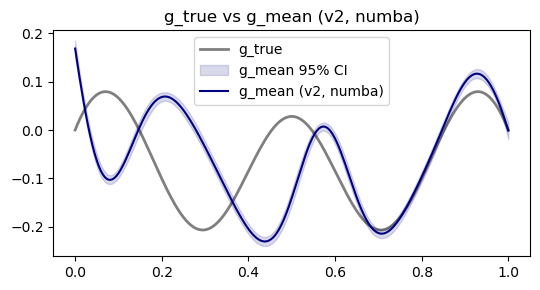

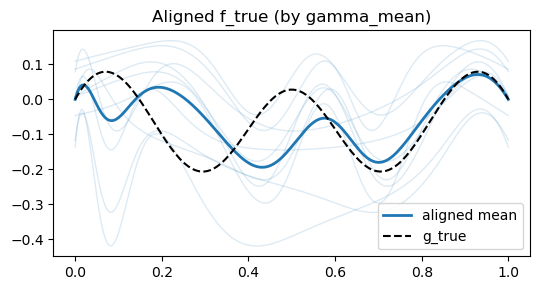

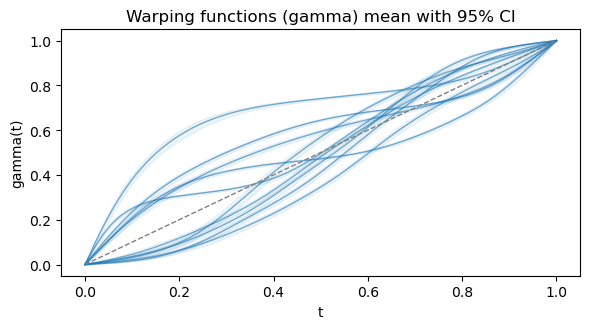

In [44]:
# --- Warping (gamma) plot after MCMC ---

plt.figure(figsize=(5.5, 3.0))
plt.plot(t, g_true, color="black", lw=2, alpha=0.5, label="g_true")
plt.fill_between(t, g_ci_lower, g_ci_upper, color='navy', alpha=0.15, label='g_mean 95% CI')
plt.plot(t, g_mean, color="navy", lw=1.5, label="g_mean (v2, numba)")
plt.legend()
plt.title("g_true vs g_mean (v2, numba)")
plt.tight_layout()
plt.show()

# --- Alignment visualization (using gamma_mean) ---
try:
    if "GammaInv" in globals() and "f_true" in globals():
        gam_mean = np.mean(np.asarray(GammaInv), axis=0)
        f_aligned = np.array([np.interp(gam_mean[i], t, f_true[i]) for i in range(num_obs)])
        f_mean = np.mean(f_true, axis=0)
        f_aligned_mean = np.mean(f_aligned, axis=0)

        plt.figure(figsize=(5.5, 3.0))
        for i in range(num_obs):
            plt.plot(t, f_aligned[i], color="tab:blue", alpha=0.15, lw=1)
        plt.plot(t, f_aligned_mean, color="tab:blue", lw=2, label="aligned mean")
        plt.plot(t, g_true, color="black", lw=1.5, ls="--", label="g_true")
        plt.title("Aligned f_true (by gamma_mean)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("[align] Missing GammaInv or f_true; skip alignment plot.")
except Exception as e:
    print(f"[align] failed: {e}")

if 'GammaInv' not in globals():
    raise RuntimeError('GammaInv not found. Run MCMC cell first.')

GammaArr = np.asarray(GammaInv)
if GammaArr.ndim != 3:
    raise RuntimeError('GammaInv has unexpected shape.')

burn = int(min(burn_iter, GammaArr.shape[0]))
gamma_chain = GammaArr[burn:] if GammaArr.shape[0] > burn else GammaArr
gamma_mean = np.mean(gamma_chain, axis=0)
gamma_lo = np.percentile(gamma_chain, 2.5, axis=0)
gamma_hi = np.percentile(gamma_chain, 97.5, axis=0)

plt.figure(figsize=(6.0, 3.4))
for i in range(num_obs):
    plt.plot(t, gamma_mean[i], color='tab:blue', alpha=0.6, lw=1)
    plt.fill_between(t, gamma_lo[i], gamma_hi[i], color='tab:blue', alpha=0.08)
plt.plot(t, t, color='gray', ls='--', lw=1, label='identity')
plt.title('Warping functions (gamma) mean with 95% CI')
plt.xlabel('t')
plt.ylabel('gamma(t)')
plt.tight_layout()
plt.show()



In [ ]:
## MCMC (report python Alg3 v2) + compare
np.random.seed(2)

# Disable Alg3 cache by default (sensitivity cache only)
USE_ALG3_CACHE = False

t_py = np.linspace(0, 1, num_points)
y_py = ys.copy() if "ys" in globals() else y.copy()
s2y_py = float(s2y)
update_s2y_py = bool(update_s2y)

cache_params = {
    "cache_tag": str(cache_tag),
    "K": int(K),
    "seed": 2,
    "s2y": float(s2y_py),
    "update_s2y": bool(update_s2y_py),
    "ell_h": float(ell_h),
    "nu_h": float(nu_h),
    "ell_g": float(ell_g),
    "nu_g": float(nu_g),
    "cov_kernel_h": str(cov_kernel_h),
    "cov_kernel_g": str(cov_kernel_g),
    "a_hyper": {"mean": float(a_hyper["mean"]), "var": float(a_hyper["var"])},
    "c_hyper": {"shape": float(c_hyper["shape"]), "scale": float(c_hyper["scale"])},
    "beta_h_choices": np.asarray(beta_h_choices, dtype=float).tolist(),
    "beta_g_choices": np.asarray(beta_g_choices, dtype=float).tolist(),
    "num_obs": int(num_obs),
    "num_points": int(num_points),
    "algo": "alg3_v2_py",
}
if update_s2y_py:
    cache_params["s2y_hyper"] = {
        "shape": float(s2y_hyper["shape"]),
        "scale": float(s2y_hyper["scale"]),
    }

cache_key = make_cache_key(cache_params, y_py, t_py)
cache_path = Path("section2.4.1") / "cache" / f"alg3_report_{cache_key}.npz"
cache = load_cache(cache_path) if USE_ALG3_CACHE else None

if cache is not None:
    print(f"[Alg3 cache] Loaded: {cache['path']}")
    arrays = cache["arrays"]
    G_py = arrays["G_py"]
    G_old_py = arrays.get("G_old_py", G_py)
    GammaInv_py = arrays["GammaInv_py"]
    C_py = arrays["C_py"]
    A_py = arrays["A_py"]
    Alpha_py = arrays.get("Alpha_py", None)
    F_py = arrays.get("F_py")
    SSE_py = arrays.get("SSE_py")
    LogLikihood_py = arrays.get("LogLikihood_py")
    Beta_h_py = arrays.get("Beta_h_py")
    Beta_g_py = arrays.get("Beta_g_py")
    S2y_py = arrays.get("S2y_py")
else:
    mcmc_out = run_alg3_chain(
        y_local=y_py,
        t=t_py,
        ell_h=ell_h,
        nu_h=nu_h,
        ell_g=ell_g,
        nu_g=nu_g,
        cov_kernel_h=cov_kernel_h,
        cov_kernel_g=cov_kernel_g,
        K=K,
        dispFreq=min(5000, int(K)),
        s2y=s2y_py,
        beta_h_choices=beta_h_choices,
        beta_g_choices=beta_g_choices,
        update_s2y=update_s2y_py,
        s2y_hyper=s2y_hyper if update_s2y_py else None,
        a_hyper=a_hyper,
        c_hyper=c_hyper,
        seed=2,
        burn=int(burn_iter),
        thin=1,
        collect_traces=True,
        display_plots=False,
        g_true=g_true if "g_true" in globals() else None,
        use_python=True,
    )

    G_py = np.asarray(mcmc_out["G"])
    G_old_py = np.asarray(mcmc_out.get("G_old", mcmc_out["G"]))
    GammaInv_py = np.asarray(mcmc_out["GammaInv"])
    C_py = np.asarray(mcmc_out["C"])
    A_py = np.asarray(mcmc_out["A"])
    Alpha_py = np.asarray(mcmc_out.get("Alpha", []))
    F_py = np.asarray(mcmc_out["F"])
    SSE_py = np.asarray(mcmc_out["SSE"])
    LogLikihood_py = np.asarray(mcmc_out["LogLikihood"])
    Beta_h_py = np.asarray(mcmc_out["Beta_h"])
    Beta_g_py = np.asarray(mcmc_out["Beta_g"])
    S2y_py = np.asarray(mcmc_out["S2y"])
acc_h_mean_py = mcmc_out.get("Acc_h_mean") if 'mcmc_out' in locals() else None
acc_g_mean_py = mcmc_out.get("Acc_g_mean") if 'mcmc_out' in locals() else None
if acc_h_mean_py is None:
    acc_h_chain = np.asarray(mcmc_out.get("Acc_rate_hInv", [])) if 'mcmc_out' in locals() else np.asarray([])
    acc_h_mean_py = float(np.mean(acc_h_chain)) if acc_h_chain.size > 0 else float("nan")
if acc_g_mean_py is None:
    acc_g_chain = np.asarray(mcmc_out.get("Acc_g", [])) if 'mcmc_out' in locals() else np.asarray([])
    acc_g_mean_py = float(np.mean(acc_g_chain)) if acc_g_chain.size > 0 else float("nan")
print(f"[MCMC-PY] Acc_h={acc_h_mean_py:.3f}, Acc_g={acc_g_mean_py:.3f}")

if USE_ALG3_CACHE:
    save_cache(
        cache_path,
        cache_params,
        {
            "G_py": G_py,
            "G_old_py": G_old_py,
            "GammaInv_py": GammaInv_py,
            "C_py": C_py,
            "A_py": A_py,
            "Alpha_py": Alpha_py,
            "F_py": F_py,
            "SSE_py": SSE_py,
            "LogLikihood_py": LogLikihood_py,
            "Beta_h_py": Beta_h_py,
            "Beta_g_py": Beta_g_py,
            "S2y_py": S2y_py,
        },
    )
    print(f"[Alg3 cache] Saved: {cache_path}")



In [ ]:
## Plot: numba vs python Alg3 comparison

def _mean_chain_local(arr):
    arr = np.asarray(arr)
    if arr.size == 0:
        return None
    return np.mean(arr, axis=0)

if 'G' in globals() and 'G_py' in globals():
    g_chain = G_old if "G_old" in globals() else G
    g_mean = _mean_chain_local(g_chain)
    g_mean_py = _mean_chain_local(G_py)
    gam_mean = _mean_chain_local(GammaInv)
    gam_mean_py = _mean_chain_local(GammaInv_py)
    if g_mean is not None and g_mean_py is not None:
        print("g_mean max abs diff:", float(np.max(np.abs(g_mean - g_mean_py))))
    if gam_mean is not None and gam_mean_py is not None:
        print("gamma_mean max abs diff:", float(np.max(np.abs(gam_mean - gam_mean_py))))



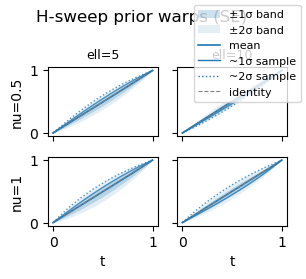

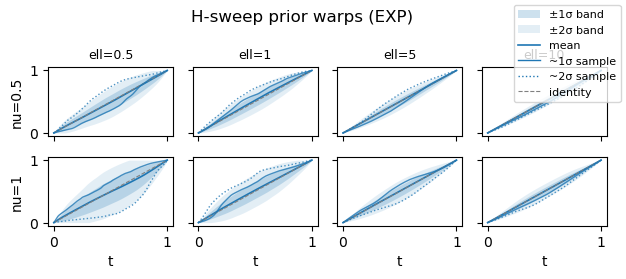

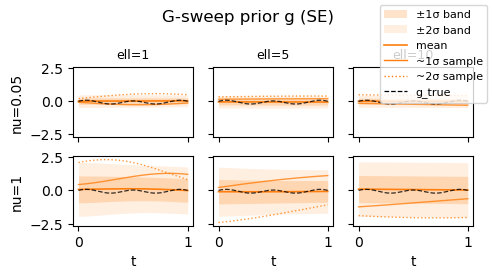

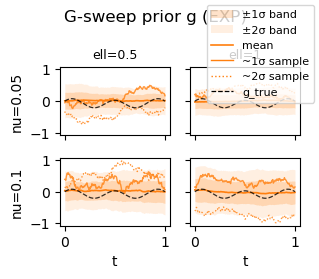

In [45]:
# Prior band visualization (H-sweep / G-sweep)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.integrate import cumulative_trapezoid

num_samples = 100
seed_samples = 2

# Grids (no anchors)
h_exp_nu = [0.5, 1]
h_exp_ell = [0.5, 1, 5, 10]

h_se_nu = [0.5, 1.0]
h_se_ell = [5, 10]

g_se_nu = [0.05, 1]
g_se_ell = [1, 5, 10]

g_exp_ell = [0.5, 1]
g_exp_nu = [0.05, 0.1]


def _sample_gp(t, nu, ell, kernel, n, rng):
    _, L = compute_covariance(t, nu, ell, kernel)
    z = rng.standard_normal((n, t.size))
    return z @ L.T


def _h_to_gamma_stack(h_stack, t):
    gamma_stack = np.zeros_like(h_stack)
    for i in range(h_stack.shape[0]):
        exp_h = np.exp(h_stack[i])
        gam = cumulative_trapezoid(exp_h, t, initial=0)
        scale = np.trapezoid(exp_h, t)
        if scale <= 0:
            scale = 1.0
        gamma_stack[i] = gam / scale
    return np.clip(gamma_stack, t[0], t[-1])


def _plot_band(ax, t, mean, std, color, clip=None):
    lo2 = mean - 2.0 * std
    hi2 = mean + 2.0 * std
    lo1 = mean - 1.0 * std
    hi1 = mean + 1.0 * std
    if clip is not None:
        lo2 = np.clip(lo2, clip[0], clip[1])
        hi2 = np.clip(hi2, clip[0], clip[1])
        lo1 = np.clip(lo1, clip[0], clip[1])
        hi1 = np.clip(hi1, clip[0], clip[1])
    ax.fill_between(t, lo2, hi2, color=color, alpha=0.12, linewidth=0)
    ax.fill_between(t, lo1, hi1, color=color, alpha=0.22, linewidth=0)
    ax.plot(t, mean, color=color, linewidth=1.2)


def _pick_sigma_samples(stack, mean, std):
    avg_std = float(np.mean(std))
    dists = np.sqrt(np.mean((stack - mean[None, :]) ** 2, axis=1))
    idx_1s = int(np.argmin(np.abs(dists - avg_std)))
    idx_2s = int(np.argmin(np.abs(dists - 2.0 * avg_std)))
    return idx_1s, idx_2s


def _plot_warp_grid(kernel, ell_grid, nu_grid, title):
    nrows = len(nu_grid)
    ncols = len(ell_grid)
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(1.6 * ncols, 1.4 * nrows),
        sharex=True,
        sharey=True,
    )
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = axes.reshape(1, -1)
    elif ncols == 1:
        axes = axes.reshape(-1, 1)

    for r, nu in enumerate(nu_grid):
        for c, ell in enumerate(ell_grid):
            ax = axes[r, c]
            seed = seed_samples + 10000 * (0 if kernel == 'se' else 1) + 100 * r + c
            rng = np.random.default_rng(seed)
            h_samps = _sample_gp(t, nu, ell, kernel, num_samples, rng)
            gamma_stack = _h_to_gamma_stack(h_samps, t)
            mean = gamma_stack.mean(axis=0)
            std = gamma_stack.std(axis=0)
            _plot_band(ax, t, mean, std, color='tab:blue', clip=(t[0], t[-1]))
            ax.plot(t, t, '--', color='gray', linewidth=0.8)

            # 1σ and 2σ sample curves (only)
            idx_1s, idx_2s = _pick_sigma_samples(gamma_stack, mean, std)
            ax.plot(t, gamma_stack[idx_1s], color='tab:blue', alpha=0.8, lw=1.0)
            ax.plot(t, gamma_stack[idx_2s], color='tab:blue', alpha=0.8, lw=1.0, ls=':')

            if r == 0:
                ax.set_title(f"ell={ell:.3g}", fontsize=9)
            if c == 0:
                ax.set_ylabel(f"nu={nu:.3g}")
            if r == nrows - 1:
                ax.set_xlabel('t')

    legend_items = [
        Patch(facecolor='tab:blue', alpha=0.22, label='±1σ band'),
        Patch(facecolor='tab:blue', alpha=0.12, label='±2σ band'),
        Line2D([0], [0], color='tab:blue', lw=1.2, label='mean'),
        Line2D([0], [0], color='tab:blue', lw=1.0, label='~1σ sample'),
        Line2D([0], [0], color='tab:blue', lw=1.0, ls=':', label='~2σ sample'),
        Line2D([0], [0], color='gray', lw=0.8, ls='--', label='identity'),
    ]
    fig.suptitle(title, fontsize=12)
    fig.legend(handles=legend_items, loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()


def _plot_g_grid(kernel, ell_grid, nu_grid, title):
    nrows = len(nu_grid)
    ncols = len(ell_grid)
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(1.6 * ncols, 1.4 * nrows),
        sharex=True,
        sharey=True,
    )
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = axes.reshape(1, -1)
    elif ncols == 1:
        axes = axes.reshape(-1, 1)

    for r, nu in enumerate(nu_grid):
        for c, ell in enumerate(ell_grid):
            ax = axes[r, c]
            seed = seed_samples + 20000 * (0 if kernel == 'se' else 1) + 100 * r + c
            rng = np.random.default_rng(seed)
            g_samps = _sample_gp(t, nu, ell, kernel, num_samples, rng)
            mean = g_samps.mean(axis=0)
            std = g_samps.std(axis=0)
            _plot_band(ax, t, mean, std, color='tab:orange')

            # 1σ and 2σ sample curves (only)
            idx_1s, idx_2s = _pick_sigma_samples(g_samps, mean, std)
            ax.plot(t, g_samps[idx_1s], color='tab:orange', alpha=0.8, lw=1.0)
            ax.plot(t, g_samps[idx_2s], color='tab:orange', alpha=0.8, lw=1.0, ls=':')

            if 'g_true' in globals() and g_true is not None:
                ax.plot(t, g_true, color='black', lw=0.9, ls='--', alpha=0.8)

            if r == 0:
                ax.set_title(f"ell={ell:.3g}", fontsize=9)
            if c == 0:
                ax.set_ylabel(f"nu={nu:.3g}")
            if r == nrows - 1:
                ax.set_xlabel('t')

    legend_items = [
        Patch(facecolor='tab:orange', alpha=0.22, label='±1σ band'),
        Patch(facecolor='tab:orange', alpha=0.12, label='±2σ band'),
        Line2D([0], [0], color='tab:orange', lw=1.2, label='mean'),
        Line2D([0], [0], color='tab:orange', lw=1.0, label='~1σ sample'),
        Line2D([0], [0], color='tab:orange', lw=1.0, ls=':', label='~2σ sample'),
        Line2D([0], [0], color='black', lw=0.9, ls='--', label='g_true'),
    ]
    fig.suptitle(title, fontsize=12)
    fig.legend(handles=legend_items, loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()


_plot_warp_grid('se', h_se_ell, h_se_nu, 'H-sweep prior warps (SE)')
_plot_warp_grid('exp', h_exp_ell, h_exp_nu, 'H-sweep prior warps (EXP)')

_plot_g_grid('se', g_se_ell, g_se_nu, 'G-sweep prior g (SE)')
_plot_g_grid('exp', g_exp_ell, g_exp_nu, 'G-sweep prior g (EXP)')


[stage1_full] total cfgs: 24


stage1_full:   0%|          | 0/24 [00:00<?, ?it/s]

[logs] merged -> /tmp/section2_4_1_st_v3_logs/stage1_full_merged.txt

Saved anchors to fig/section2_4_1_st_v3/anchors_stage1.json
{
  "anchor_h_se": null,
  "anchor_h_exp": {
    "s2y": 0.1,
    "cov_kernel_h": "exp",
    "nu_h": 1.0,
    "ell_h": 10.0,
    "cov_kernel_g": "se",
    "nu_g": 0.1,
    "ell_g": 0.01,
    "c_hyper": {
      "shape": 10.0,
      "scale": 0.1
    },
    "a_hyper": {
      "mean": 0,
      "var": 0.1
    },
    "beta_h_choices": [
      0.03,
      0.05,
      0.07,
      0.1,
      0.14,
      0.2,
      0.28,
      0.35,
      0.45
    ],
    "beta_g_choices": [
      0.002,
      0.003,
      0.005,
      0.01,
      0.02,
      0.035,
      0.05,
      0.07,
      0.1
    ],
    "verbose": false,
    "beta_adapt": true,
    "beta_n_adapt": 1500,
    "beta_window": 100,
    "beta_acc_target_h": 0.25,
    "beta_acc_target_g": 0.25,
    "beta_c_h": 0.15,
    "beta_c_g": 0.15,
    "beta_fixed": 0.35,
    "beta_h_fixed_prob": 0.05,
    "beta_g_fixed_prob": 0.0

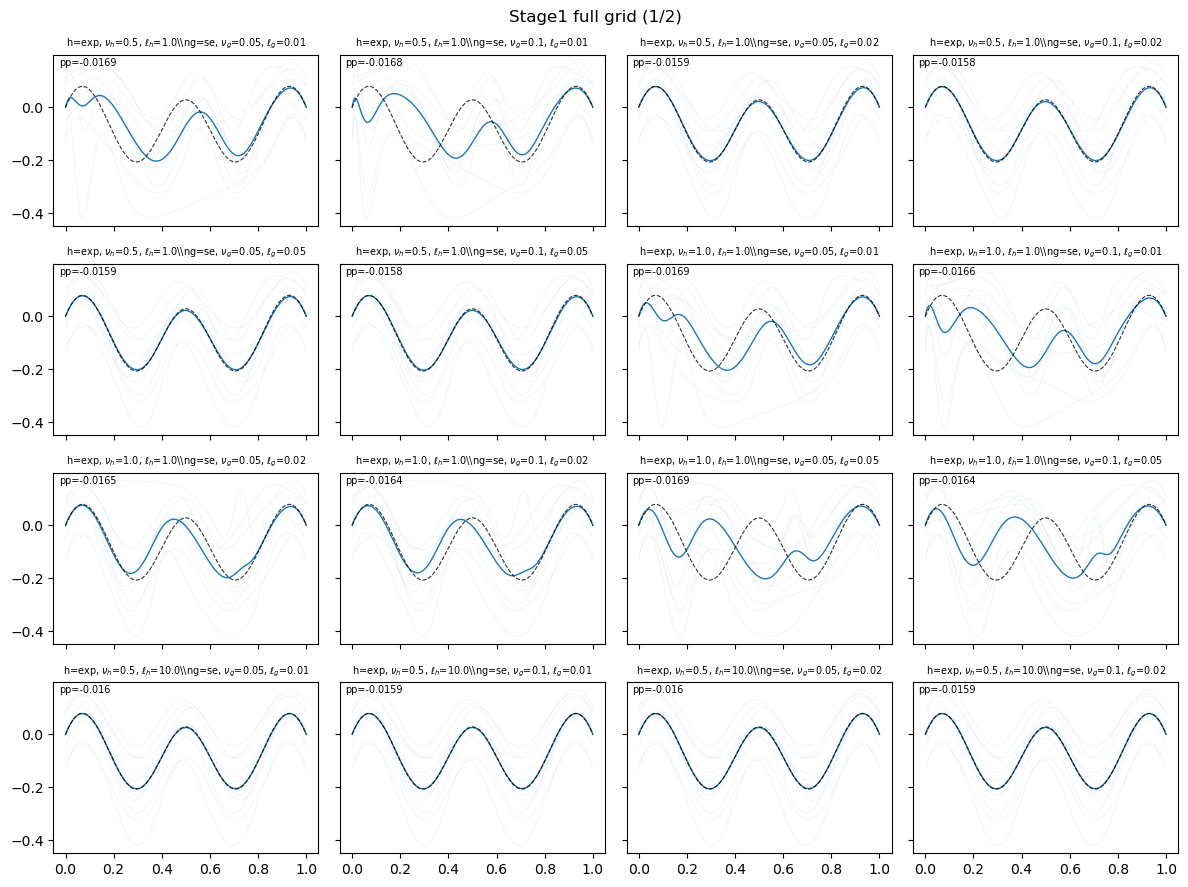

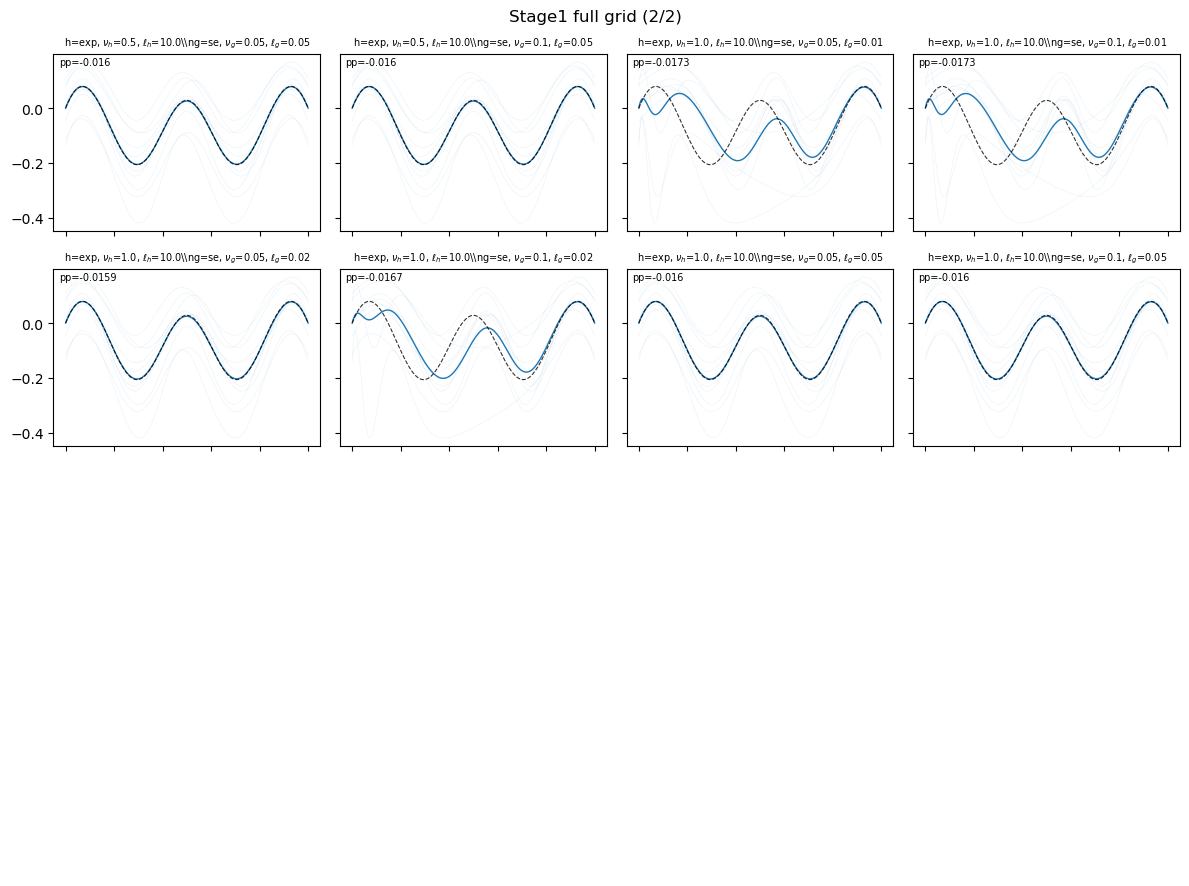

[anchor] h=exp (nu=1.0, ell=10.0) | g=se (nu=0.1, ell=0.01)


In [ ]:
## Stage 1: Anchor search (rough grid)
import os
from pathlib import Path
import numpy as np
import json
# Ensure data is loaded
if 'y' not in globals() or 't' not in globals():
    data_path = Path("section2.4.1") / "data_st.npz"
    if not data_path.exists():
        raise FileNotFoundError(f"Missing data file: {data_path}. Run section2.4.1_st_data.ipynb first.")
    data = np.load(data_path, allow_pickle=True)
    t = data["t"]
    y = data["y"]
    ys = data["ys"] if "ys" in data.files else y.copy()
    g_true = data["g_true"]
    f_true = data["f_true"]
    gamma0 = data["gamma0"]
    a_true = data["a_true"]
    c_true = data["c_true"]
    sig_y0 = float(data["sig_y0"]) if "sig_y0" in data.files else 0.2
    num_obs = int(data["num_obs"]) if "num_obs" in data.files else y.shape[0]
    num_points = int(data["num_points"]) if "num_points" in data.files else t.shape[0]

if 'foldername' not in globals():
    foldername = 'section2_4_1_st_v3'

# Baseline g (fixed while sweeping h)
baseline_g = {
    'cov_kernel_g': 'se',
    'ell_g': 0.01,
    'nu_g': 1.0,
}

# # Rough grids
# h_exp_nu = [0.5]
# h_exp_ell = [10]

# g_se_nu = [0.05]
# g_se_ell = [0.02]

h_exp_nu = [0.5, 1]
h_exp_ell = [1, 10]

g_se_nu = [0.1, 0.05]
g_se_ell = [0.01, 0.02, 0.05]

K_sens = 3000
keep_last = 500  # keep last samples for PP score
seed = 2
burn_iter = int(0.5 * K_sens)
beta_n_adapt = int(burn_iter)

os.makedirs(f"fig/{foldername}", exist_ok=True)
cache_dir_h = Path(f"fig/{foldername}") / "cache_stage1_h"
cache_dir_g = Path(f"fig/{foldername}") / "cache_stage1_g"
cache_dir_h.mkdir(parents=True, exist_ok=True)
cache_dir_g.mkdir(parents=True, exist_ok=True)


# noise for stage1 (use baseline sigma)
s2y = float(sig_y0)/2

base_cfg = {
    's2y': float(s2y),
    'cov_kernel_h': cov_kernel_h,
    'nu_h': nu_h,
    'ell_h': ell_h,
    'cov_kernel_g': cov_kernel_g,
    'nu_g': nu_g,
    'ell_g': ell_g,
    'c_hyper': c_hyper,
    'a_hyper': a_hyper,
    'beta_h_choices': beta_h_choices,
    'beta_g_choices': beta_g_choices,
    'verbose': False,
    'beta_adapt': beta_adapt,
    'beta_n_adapt': beta_n_adapt,
    'beta_window': beta_window,
    'beta_acc_target_h': beta_acc_target_h,
    'beta_acc_target_g': beta_acc_target_g,
    'beta_c_h': beta_c_h,
    'beta_c_g': beta_c_g,
    'beta_fixed': beta_fixed,
    'beta_h_fixed_prob': beta_h_fixed_prob,
    'beta_g_fixed_prob': beta_g_fixed_prob,
}

data_dict = {
    'y': y,
    't': t,
    'f_true': f_true,
    'g_true': g_true,
    'gamma0': gamma0,
    'c_true': c_true,
    'a_true': a_true,
    's2y': float(s2y),
}

def _jsonify(obj):
    if isinstance(obj, dict):
        return {k: _jsonify(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [_jsonify(v) for v in obj]
    if hasattr(obj, 'tolist'):
        return obj.tolist()
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    return obj



import contextlib
import time
import multiprocessing as _mp
_MP_CTX = _mp.get_context('fork')
_MP_WORKERS = 4


LOG_DIR = Path("/tmp") / f"{foldername}_logs"
LOG_DIR.mkdir(parents=True, exist_ok=True)

RERUN_MISSING = True
REQUIRED_FIELDS = ('acc_h_mean','acc_g_mean','ess_g_mid','gamma_ci_width','pp_mean')

def _run_cfg_stage1(*args):
    if len(args) == 1 and isinstance(args[0], tuple):
        cfg, cache_dir, tag, idx, total, log_path = args[0]
    else:
        cfg, cache_dir, tag, idx, total, log_path = args
    cache_params = dict(cfg)
    # Ensure JSON-serializable cache params
    for key in ('beta_h_choices', 'beta_g_choices'):
        if key in cache_params:
            try:
                cache_params[key] = list(cache_params[key])
            except Exception:
                pass
    for k, v in list(cache_params.items()):
        try:
            if hasattr(v, 'tolist'):
                cache_params[k] = v.tolist()
        except Exception:
            pass
    cache_params.update({
        'cache_tag': str(cache_tag),
        'K_sens': int(K_sens),
        'keep_last': int(keep_last),
        'seed': int(seed),
        'burn_iter': int(burn_iter),
        'algo': 'alg3_v2',
        'stage': 'anchor',
        'sweep': tag,
    })
    cache_key = make_cache_key(cache_params, y, t)
    cache_path = cache_dir / f"{tag}_{cache_key}.npz"

    row = None
    if cache_path.exists():
        cache = load_cache(cache_path)
        if cache is not None:
            arrays = cache.get('arrays', {})
            if RERUN_MISSING:
                missing = [k for k in REQUIRED_FIELDS if k not in arrays]
                if missing:
                    row = None
                else:
                    row = {}
            else:
                row = {}
            for k in (
                'g_nrmse', 'g_nrmse_raw', 'gamma_ci_width',
                'ls', 'pc',
                'acc_h_mean', 'acc_g_mean', 'acc_c_mean',
                'ess_g_mid', 'ess_gamma_mid', 'ess_c_mean', 'ess_a_mean',
                'elapsed_sec', 'ess_per_min',
                'pp_mean', 'pp_median', 'pp_p90', 'pp_iqr', 'pp_max',
            ):
                if k in arrays:
                    try:
                        row[k] = float(arrays[k])
                    except Exception:
                        row[k] = arrays[k]
            row['cache_path'] = str(cache_path)

    if row is None:
        start_time = time.time()
        with open(log_path, 'w') as lf:
            with contextlib.redirect_stdout(lf):
                print(f"[{tag}] {idx+1}/{total}")
                row = validation.run_pmcmc_sensitivity(
                    cfg,
                    K_sens=K_sens,
                    keep_last=keep_last,
                    seed=seed,
                    collect_summaries=True,
                    burn_frac=(burn_iter / float(K_sens)),
                    data=data_dict,
                    return_chains=True,
                )
        row = dict(row) if row is not None else {}
        row['elapsed_sec'] = float(time.time() - start_time)

        # posterior predictive score (log density up to const)
        try:
            g_chain = row.get('_g_chain')
            gamma_chain = row.get('_gamma_chain')
            if g_chain is not None and gamma_chain is not None:
                g_chain = np.asarray(g_chain)
                gamma_chain = np.asarray(gamma_chain)
                base = ys if ('ys' in globals() and ys is not None) else y
                base = np.asarray(base)
                S = min(g_chain.shape[0], gamma_chain.shape[0])
                S_use = min(S, 1000)
                if S_use > 0:
                    idxs = np.linspace(0, S-1, S_use).astype(int)
                    ll_vals = []
                    for s in idxs:
                        gamma_s = gamma_chain[s]
                        g_s = g_chain[s]
                        n = min(num_obs, gamma_s.shape[0], base.shape[0])
                        f_aligned = np.array([np.interp(gamma_s[k], t, base[k]) for k in range(n)])
                        resid = f_aligned - g_s[None, :]
                        ll_vals.append(-0.5 * float(np.mean(resid ** 2)))
                    ll_vals = np.asarray(ll_vals, dtype=float)
                    if np.all(np.isfinite(ll_vals)):
                        row['pp_mean'] = float(np.mean(ll_vals))
                        row['pp_median'] = float(np.median(ll_vals))
                        row['pp_p90'] = float(np.quantile(ll_vals, 0.90))
                        row['pp_iqr'] = float(np.quantile(ll_vals, 0.75) - np.quantile(ll_vals, 0.25))
                        row['pp_max'] = float(np.max(ll_vals))
        except Exception:
            pass

        # drop chains to keep cache light
        for _k in ('_g_chain','_gamma_chain','_c_chain','_a_chain','_alpha_chain'):
            if _k in row:
                row.pop(_k, None)

        summary_keys = (
            '_g_mean', '_g_ci_lower', '_g_ci_upper',
            '_g_old_mean', '_g_old_ci_lower', '_g_old_ci_upper',
            '_gamma_mean', '_gamma_ci_lower', '_gamma_ci_upper',
        )
        summary = {k: row.pop(k) for k in summary_keys if k in row}
        for k in (
            'g_nrmse', 'g_nrmse_raw', 'gamma_ci_width',
            'ls', 'pc',
            'acc_h_mean', 'acc_g_mean', 'acc_c_mean',
            'ess_g_mid', 'ess_gamma_mid', 'ess_c_mean', 'ess_a_mean',
            'elapsed_sec', 'ess_per_min',
            'pp_mean', 'pp_median', 'pp_p90', 'pp_iqr', 'pp_max',
        ):
            if k in row:
                summary[k] = np.asarray(row[k])
        if summary:
            save_cache(cache_path, cache_params, summary)

        row['cache_path'] = str(cache_path)

    row_full = dict(cfg)
    row_full.update(row)
    row_full['cache_path'] = str(cache_path)
    return row_full


def _merge_logs(tag, log_paths):
    merged_path = LOG_DIR / f"{tag}_merged.txt"
    with open(merged_path, 'w') as mf:
        for p in log_paths:
            if not p.exists():
                continue
            mf.write(f"===== {p.name} =====\n")
            mf.write(p.read_text())
            mf.write('\n')
    print(f"[logs] merged -> {merged_path}")
    print(merged_path.read_text())
    for p in log_paths:
        try:
            p.unlink()
        except Exception:
            pass



try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None


def _run_sweep(cfgs, cache_dir, tag):
    results = []
    total = len(cfgs)
    log_paths = []
    args = []
    for i, cfg in enumerate(cfgs):
        lp = LOG_DIR / f"{tag}_{i}.txt"
        log_paths.append(lp)
        args.append((cfg, cache_dir, tag, i, total, lp))

    pbar = tqdm(total=total, desc=tag) if tqdm else None
    try:
        with _MP_CTX.Pool(processes=_MP_WORKERS) as pool:
            for row_full in pool.imap_unordered(_run_cfg_stage1, args):
                results.append(row_full)
                if pbar:
                    pbar.update(1)
                else:
                    print(f"[{tag}] {len(results)}/{total}")
    except Exception as e:
        print(f"[mp] fallback to serial due to: {e}")
        for i, cfg in enumerate(cfgs):
            row_full = _run_cfg_stage1(cfg, cache_dir, tag, i, total, log_paths[i])
            results.append(row_full)
            if pbar:
                pbar.update(1)
            else:
                print(f"[{tag}] {i+1}/{total}")
    if pbar:
        pbar.close()
    _merge_logs(tag, log_paths)
    return results

def _ls_stats_from_row(row):
    if row is None:
        return None
    # if pp stats already present (from cache), just return them
    if row.get('pp_mean') is not None:
        stats = {
            'pp_mean': float(row.get('pp_mean')),
            'pp_median': float(row.get('pp_median')) if row.get('pp_median') is not None else float('nan'),
            'pp_p90': float(row.get('pp_p90')) if row.get('pp_p90') is not None else float('nan'),
            'pp_iqr': float(row.get('pp_iqr')) if row.get('pp_iqr') is not None else float('nan'),
            'pp_max': float(row.get('pp_max')) if row.get('pp_max') is not None else float('nan'),
        }
        row.update(stats)
        return stats

    cache_path = row.get('cache_path')
    if not cache_path or not Path(cache_path).exists():
        return None
    try:
        cache = load_cache(cache_path)
    except Exception:
        cache = None
    if cache is None:
        return None
    arrays = cache.get('arrays', {})
    gamma_chain = arrays.get('_gamma_chain') if '_gamma_chain' in arrays else arrays.get('Gamma')
    g_chain = arrays.get('_g_chain') if '_g_chain' in arrays else arrays.get('G')
    if gamma_chain is None or g_chain is None:
        return None
    try:
        gamma_chain = np.asarray(gamma_chain)
        g_chain = np.asarray(g_chain)
        if gamma_chain.ndim != 3:
            return None
        if g_chain.ndim != 2:
            return None
    except Exception:
        return None

    base = None
    if 'ys' in globals() and ys is not None:
        base = ys
    elif 'y' in globals():
        base = y
    if base is None:
        return None
    try:
        base = np.asarray(base)
        S = min(gamma_chain.shape[0], g_chain.shape[0])
        if S == 0:
            return None
        S_use = min(S, 1000)
        idxs = np.linspace(0, S-1, S_use).astype(int)
        ll_vals = []
        for s in idxs:
            gamma_s = gamma_chain[s]
            g_s = g_chain[s]
            n = min(num_obs, gamma_s.shape[0], base.shape[0])
            f_aligned = np.array([np.interp(gamma_s[k], t, base[k]) for k in range(n)])
            resid = f_aligned - g_s[None, :]
            ll_vals.append(-0.5 * float(np.mean(resid ** 2)))
        ll_vals = np.asarray(ll_vals, dtype=float)
        if not np.all(np.isfinite(ll_vals)):
            return None
    except Exception:
        return None

    stats = {
        'pp_mean': float(np.mean(ll_vals)),
        'pp_median': float(np.median(ll_vals)),
        'pp_p90': float(np.quantile(ll_vals, 0.90)),
        'pp_iqr': float(np.quantile(ll_vals, 0.75) - np.quantile(ll_vals, 0.25)),
        'pp_max': float(np.max(ll_vals)),
    }
    row.update(stats)
    return stats


def _select_best(rows, kernel_key, kernel_val, prefer_metric='pp_mean'):
    cand = [r for r in rows if r.get(kernel_key) == kernel_val]
    if not cand:
        return None

def _select_best_joint(rows, cov_h='exp', cov_g='se', prefer_metric='pp_mean'):
    cand = [r for r in rows if r.get('cov_kernel_h') == cov_h and r.get('cov_kernel_g') == cov_g]
    if not cand:
        return None
    # reuse _select_best logic by faking kernel_key
    # but for joint selection we just pick best by metric directly
    use_metric = prefer_metric
    if use_metric is None:
        return cand[0]
    maximize_metrics = {'pc', 'acc_h_mean', 'acc_g_mean', 'acc_c_mean',
                        'ess_g_mid', 'ess_gamma_mid', 'ess_c_mean', 'ess_a_mean', 'ess_per_min',
                        'pp_mean', 'pp_median', 'pp_p90', 'pp_max'}
    minimize_metrics = {'ls', 'sls', 'g_nrmse', 'g_nrmse_raw', 'gamma_ci_width'}

    def score(r):
        v = r.get(use_metric)
        if v is None:
            return float('-inf') if use_metric in maximize_metrics else float('inf')
        return float(v)

    if use_metric in maximize_metrics:
        return max(cand, key=score)
    if use_metric in minimize_metrics:
        return min(cand, key=score)
    return max(cand, key=score)


    # robust LS selection (noise-free f vs g_true)
    if prefer_metric in ('ls_robust', 'ls'):
        scored = []
        for r in cand:
            stats = _ls_stats_from_row(r)
            if stats is None:
                continue
            scored.append((-stats['pp_mean'], -stats['pp_p90'], stats['pp_iqr'], r))
        if scored:
            scored.sort(key=lambda x: (x[0], x[1], x[2]))
            return scored[0][3]

    # fallback to available scalar metrics
    use_metric = None
    if prefer_metric and any(r.get(prefer_metric) is not None for r in cand):
        use_metric = prefer_metric
    elif any(r.get('g_nrmse') is not None for r in cand):
        use_metric = 'g_nrmse'
    else:
        use_metric = None

    if use_metric is None:
        return cand[0]

    minimize_metrics = {'ls', 'sls', 'g_nrmse', 'g_nrmse_raw', 'gamma_ci_width'}
    maximize_metrics = {'pc', 'acc_h_mean', 'acc_g_mean', 'acc_c_mean',
                        'ess_g_mid', 'ess_gamma_mid', 'ess_c_mean', 'ess_a_mean', 'ess_per_min'}

    def score(r):
        v = r.get(use_metric)
        return float(v) if v is not None else (float('inf') if use_metric in minimize_metrics else float('-inf'))

    if use_metric in minimize_metrics:
        return min(cand, key=score)
    if use_metric in maximize_metrics:
        return max(cand, key=score)

    return min(cand, key=score)


def _plot_anchor_alignment(row, title):
    if row is None:
        return
    cache_path = row.get('cache_path')
    if not cache_path or not Path(cache_path).exists():
        return
    cache = load_cache(cache_path)
    if cache is None:
        return
    arrays = cache.get('arrays', {})
    gamma_mean = arrays.get('_gamma_mean') if '_gamma_mean' in arrays else arrays.get('gamma_mean')
    if gamma_mean is None:
        return
    f_aligned = np.array([np.interp(gamma_mean[k], t, f_true[k]) for k in range(num_obs)])
    f_aligned_mean = np.mean(f_aligned, axis=0)
    plt.figure(figsize=(5.6, 3.0))
    for k in range(num_obs):
        plt.plot(t, f_aligned[k], color='tab:blue', alpha=0.12, lw=0.6)
    plt.plot(t, f_aligned_mean, color='tab:blue', lw=1.4, label='aligned mean')
    plt.plot(t, g_true, color='black', lw=1.0, ls='--', label='g_true')
    h_kernel = row.get('cov_kernel_h','?')
    g_kernel = row.get('cov_kernel_g','?')
    h_nu = row.get('nu_h','?')
    h_ell = row.get('ell_h','?')
    g_nu = row.get('nu_g','?')
    g_ell = row.get('ell_g','?')
    title_fmt = (
        rf"h={h_kernel}, $\nu_h$={h_nu}, $\ell_h$={h_ell} || "
        rf"g={g_kernel}, $\nu_g$={g_nu}, $\ell_g$={g_ell}"
    )
    plt.title(title_fmt)
    plt.legend(frameon=False, fontsize=8)
    plt.tight_layout()
    plt.show()



def _plot_stage1_grid(rows, title_prefix, start_idx=0, max_plots=16):
    if not rows:
        return
    end_idx = min(start_idx + max_plots, len(rows))
    subset = rows[start_idx:end_idx]
    n = len(subset)
    if n == 0:
        return
    nrows = 4
    ncols = 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(12.0, 9.0), sharex=True, sharey=True)
    axes = axes.reshape(nrows, ncols)

    for i in range(nrows * ncols):
        ax = axes.flat[i]
        if i >= n:
            ax.axis('off')
            continue
        row = subset[i]
        cache_path = row.get('cache_path')
        if not cache_path or not Path(cache_path).exists():
            ax.text(0.5, 0.5, 'missing', ha='center', va='center', fontsize=8)
            ax.axis('off')
            continue
        cache = load_cache(cache_path)
        if cache is None:
            ax.text(0.5, 0.5, 'cache fail', ha='center', va='center', fontsize=8)
            ax.axis('off')
            continue
        arrays = cache.get('arrays', {})
        gamma_mean = arrays.get('_gamma_mean') if '_gamma_mean' in arrays else arrays.get('gamma_mean')
        if gamma_mean is None:
            ax.text(0.5, 0.5, 'no gamma', ha='center', va='center', fontsize=8)
            ax.axis('off')
            continue
        f_aligned = np.array([np.interp(gamma_mean[k], t, f_true[k]) for k in range(num_obs)])
        f_aligned_mean = np.mean(f_aligned, axis=0)
        for k in range(num_obs):
            ax.plot(t, f_aligned[k], color='tab:blue', alpha=0.08, lw=0.5)
        ax.plot(t, f_aligned_mean, color='tab:blue', lw=1.0)
        ax.plot(t, g_true, color='black', lw=0.8, ls='--', alpha=0.8)

        ls_val = row.get('pp_mean', None)
        try:
            if ls_val is not None and np.isfinite(ls_val):
                ax.text(0.02, 0.98, f"pp={float(ls_val):.3g}",
                        transform=ax.transAxes, ha='left', va='top', fontsize=7)
        except Exception:
            pass

        title = (
            rf"h={row.get('cov_kernel_h','?')}, $\nu_h$={row.get('nu_h','?')}, $\ell_h$={row.get('ell_h','?')} || "
            rf"g={row.get('cov_kernel_g','?')}, $\nu_g$={row.get('nu_g','?')}, $\ell_g$={row.get('ell_g','?')}"
        )
        ax.set_title(title, fontsize=7)

    fig.suptitle(title_prefix, fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Stage 1 sweeps (full grid: h=exp × g=se) ---
cache_tag = 'stage1_full'

cache_dir_stage1 = Path(f"fig/{foldername}") / "cache_stage1_full"
cache_dir_stage1.mkdir(parents=True, exist_ok=True)

cfgs = []
# h = EXP grid
for ell_h in h_exp_ell:
    for nu_h in h_exp_nu:
        for ell_g in g_se_ell:
            for nu_g in g_se_nu:
                cfg = dict(base_cfg)
                cfg.update({
                    'cov_kernel_h': 'exp',
                    'ell_h': float(ell_h),
                    'nu_h': float(nu_h),
                    'cov_kernel_g': 'se',
                    'ell_g': float(ell_g),
                    'nu_g': float(nu_g),
                })
                cfg['label'] = (
                    f"h(exp): ell_h={ell_h}, nu_h={nu_h} | "
                    f"g(se): ell_g={ell_g}, nu_g={nu_g}"
                )
                cfg['ls_on_y'] = False
                cfgs.append(cfg)

print(f"[stage1_full] total cfgs: {len(cfgs)}")

results_stage1 = _run_sweep(cfgs, cache_dir_stage1, 'stage1_full')

# Plot anchor alignments (moved to anchor-selection cell)
# Select anchors from full grid (best per kernel (h=exp only, g=se only))
# joint anchor by pp_mean over h=exp & g=se
anchor_row = _select_best_joint(results_stage1, cov_h='exp', cov_g='se', prefer_metric='pp_mean')
anchor_h_exp = anchor_row if anchor_row is not None else _select_best(results_stage1, 'cov_kernel_h', 'exp')
anchor_h_se = None
anchor_g_se = anchor_row if anchor_row is not None else _select_best(results_stage1, 'cov_kernel_g', 'se')
anchor_g_exp = None

anchors = {
    'anchor_h_se': _jsonify(anchor_h_se),
    'anchor_h_exp': _jsonify(anchor_h_exp),
    'anchor_g_se': _jsonify(anchor_g_se),
    'anchor_g_exp': _jsonify(anchor_g_exp),
}
anchors_path = Path(f"fig/{foldername}") / "anchors_stage1.json"
anchors_path.write_text(json.dumps(anchors, indent=2))
print('Saved anchors to', anchors_path)
print(anchors_path.read_text())

# Show all 32 stage1 plots in two 4x4 figures
_sorted = sorted(
    results_stage1,
    key=lambda r: (
        0 if r.get('cov_kernel_h') == 'exp' else 1,
        float(r.get('ell_h', 0)),
        float(r.get('nu_h', 0)),
        float(r.get('ell_g', 0)),
        float(r.get('nu_g', 0)),
    ),
)
_plot_stage1_grid(_sorted, "Stage1 full grid (1/2)", start_idx=0, max_plots=16)
_plot_stage1_grid(_sorted, "Stage1 full grid (2/2)", start_idx=16, max_plots=16)
# one-line summary
if anchor_h_exp is not None and anchor_g_se is not None:
    print(f"[anchor] h=exp (nu={anchor_h_exp.get('nu_h')}, ell={anchor_h_exp.get('ell_h')}) | g=se (nu={anchor_g_se.get('nu_g')}, ell={anchor_g_se.get('ell_g')})")

# show alignment for anchor
if anchor_h_exp is not None and anchor_g_se is not None:
    _plot_anchor_alignment(anchor_g_se, "Anchor alignment")

# show top pp candidates
if 'results_stage1' in globals():
    _pp_rows = [r for r in results_stage1 if r.get('pp_mean') is not None]
    _pp_rows = sorted(_pp_rows, key=lambda r: r.get('pp_mean'), reverse=True)
    print('[pp] top 5 by pp_mean:')
    for r in _pp_rows[:5]:
        print(f"  pp={r.get('pp_mean'):.4g} | h={r.get('cov_kernel_h')} nu_h={r.get('nu_h')} ell_h={r.get('ell_h')} | g={r.get('cov_kernel_g')} nu_g={r.get('nu_g')} ell_g={r.get('ell_g')}")


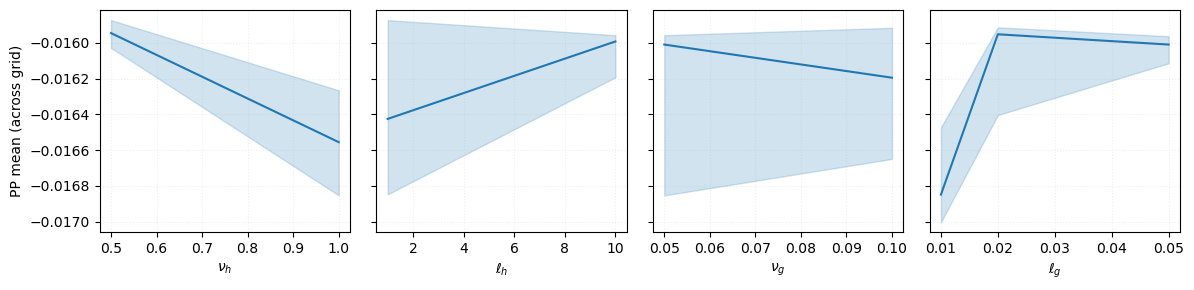

Sensitivity score (lower = less sensitive):
  nu_g: 1.85e+08
  ell_h: 4.33e+08
  nu_h: 6.1e+08
  ell_g: 8.97e+08


In [67]:
# --- Stage1 sensitivity summary (single-figure) ---
if 'results_stage1' in globals() and results_stage1:
    # compute robust LS stats if missing
    _ = [_ls_stats_from_row(r) for r in results_stage1]
    metric_key = 'pp_mean'

    def _summarize_param(param_key):
        groups = {}
        for r in results_stage1:
            if r.get(param_key) is None:
                continue
            try:
                val = float(r[param_key])
            except Exception:
                continue
            m = r.get(metric_key)
            if m is None:
                continue
            try:
                m = float(m)
            except Exception:
                continue
            if not np.isfinite(m):
                continue
            groups.setdefault(val, []).append(m)
        xs = sorted(groups.keys())
        med = []
        q25 = []
        q75 = []
        p10 = []
        p90 = []
        for x in xs:
            arr = np.asarray(groups[x], dtype=float)
            med.append(np.median(arr))
            q25.append(np.quantile(arr, 0.25))
            q75.append(np.quantile(arr, 0.75))
            p10.append(np.quantile(arr, 0.10))
            p90.append(np.quantile(arr, 0.90))
        return xs, np.array(med), np.array(q25), np.array(q75), np.array(p10), np.array(p90)

    fig, axes = plt.subplots(1, 4, figsize=(12.0, 3.0), sharey=True)
    params = [
        ('nu_h', r'$\nu_h$'),
        ('ell_h', r'$\ell_h$'),
        ('nu_g', r'$\nu_g$'),
        ('ell_g', r'$\ell_g$'),
    ]
    scores = []
    for ax, (param_key, label) in zip(axes, params):
        xs, med, q25, q75, p10, p90 = _summarize_param(param_key)
        if len(xs) == 0:
            ax.set_axis_off()
            continue
        ax.plot(xs, med, color='tab:blue', lw=1.5)
        ax.fill_between(xs, q25, q75, color='tab:blue', alpha=0.2)
        ax.set_xlabel(label)
        ax.grid(True, alpha=0.2, ls=':')
        # sensitivity score: normalized range of medians
        score = float((np.max(med) - np.min(med)) / max(np.median(med), 1e-12))
        scores.append((param_key, score))
    axes[0].set_ylabel('PP mean (across grid)')
    plt.tight_layout()
    plt.show()

    if scores:
        scores = sorted(scores, key=lambda x: x[1])
        print('Sensitivity score (lower = less sensitive):')
        for k, v in scores:
            print(f"  {k}: {v:.3g}")


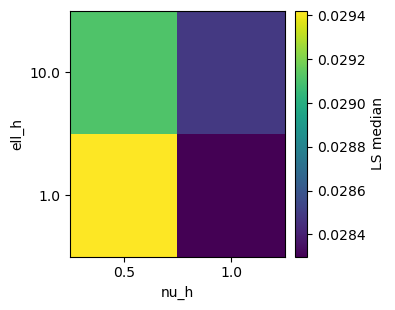

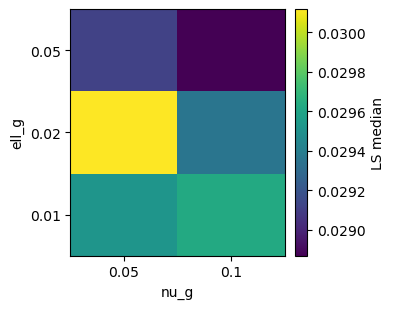

In [42]:
# --- Stage1 2D heatmaps (fix others at anchor) ---
if 'results_stage1' in globals() and results_stage1:
    # ensure robust stats exist
    _ = [_ls_stats_from_row(r) for r in results_stage1]

    # choose anchor values from robust stats (lowest p90 -> median -> IQR)
    def _best_param_value(param_key):
        groups = {}
        for r in results_stage1:
            if r.get(param_key) is None:
                continue
            try:
                v = float(r[param_key])
            except Exception:
                continue
            if r.get('ls_p90') is None:
                continue
            groups.setdefault(v, []).append((r.get('ls_p90'), r.get('ls_median'), r.get('ls_iqr')))
        if not groups:
            return None
        scored = []
        for v, stats in groups.items():
            p90 = float(np.median([s[0] for s in stats]))
            med = float(np.median([s[1] for s in stats]))
            iqr = float(np.median([s[2] for s in stats]))
            scored.append((p90, med, iqr, v))
        scored.sort(key=lambda x: (x[0], x[1], x[2]))
        return scored[0][3]

    anchor_vals = {
        'nu_h': _best_param_value('nu_h'),
        'ell_h': _best_param_value('ell_h'),
        'nu_g': _best_param_value('nu_g'),
        'ell_g': _best_param_value('ell_g'),
    }

    def _heatmap(x_key, y_key, fixed_keys):
        rows = []
        for r in results_stage1:
            ok = True
            for fk in fixed_keys:
                if anchor_vals.get(fk) is None:
                    continue
                if float(r.get(fk)) != float(anchor_vals[fk]):
                    ok = False
                    break
            if not ok:
                continue
            if r.get('pp_mean') is None:
                continue
            rows.append(r)
        if not rows:
            return
        xs = sorted({float(r.get(x_key)) for r in rows})
        ys = sorted({float(r.get(y_key)) for r in rows})
        Z = np.full((len(ys), len(xs)), np.nan)
        for r in rows:
            xi = xs.index(float(r.get(x_key)))
            yi = ys.index(float(r.get(y_key)))
            Z[yi, xi] = float(r.get('pp_mean'))
        fig, ax = plt.subplots(figsize=(4.0, 3.2))
        im = ax.imshow(Z, origin='lower', aspect='auto')
        ax.set_xticks(range(len(xs)))
        ax.set_yticks(range(len(ys)))
        ax.set_xticklabels([str(x) for x in xs])
        ax.set_yticklabels([str(y) for y in ys])
        ax.set_xlabel(x_key)
        ax.set_ylabel(y_key)
        cbar = plt.colorbar(im, ax=ax, fraction=0.08, pad=0.04)
        cbar.set_label('PP mean')
        plt.tight_layout()
        plt.show()

    # pairwise heatmaps with other params fixed at anchor
    _heatmap('nu_h', 'ell_h', fixed_keys=['nu_g', 'ell_g'])
    _heatmap('nu_g', 'ell_g', fixed_keys=['nu_h', 'ell_h'])


In [41]:
## Stage 2: Sensitivity around anchors (h=exp, g=se only)
import numpy as np
from pathlib import Path
import os
import json
import time
import contextlib

if 'foldername' not in globals():
    foldername = 'section2_4_1_st_v3'

# Load anchors if not in memory
if ('anchor_h_exp' not in globals()) or ('anchor_g_se' not in globals()):
    anchors_path = Path(f"fig/{foldername}") / "anchors_stage1.json"
    if anchors_path.exists():
        anchors = json.loads(anchors_path.read_text())
        anchor_h_exp = anchors.get('anchor_h_exp')
        anchor_g_se = anchors.get('anchor_g_se')
        print('Loaded anchors from', anchors_path)
    else:
        raise RuntimeError('anchors_stage1.json not found. Run Stage 1 first.')

# Ratio grids around anchor
r_ell = [0.2, 1/3, 1, 3, 5]
r_nu = [0.2, 1/3, 1, 3, 5]

K_sens = 10000
keep_last = 0  # use full post-burn chain
seed = 2
burn_iter = int(0.5 * K_sens)
beta_n_adapt = int(burn_iter)

cache_dir_h2 = Path(f"fig/{foldername}") / "cache_stage2_h"
cache_dir_g2 = Path(f"fig/{foldername}") / "cache_stage2_g"
cache_dir_h2.mkdir(parents=True, exist_ok=True)
cache_dir_g2.mkdir(parents=True, exist_ok=True)

# Ensure data dict
if 'y' not in globals() or 't' not in globals():
    data_path = Path("section2.4.1") / "data_st.npz"
    if not data_path.exists():
        raise FileNotFoundError(f"Missing data file: {data_path}. Run section2.4.1_st_data.ipynb first.")
    data = np.load(data_path, allow_pickle=True)
    t = data["t"]
    y = data["y"]
    ys = data["ys"] if "ys" in data.files else y.copy()
    g_true = data["g_true"]
    f_true = data["f_true"]
    gamma0 = data["gamma0"]
    a_true = data["a_true"]
    c_true = data["c_true"]
    sig_y0 = float(data["sig_y0"]) if "sig_y0" in data.files else 0.2
    num_obs = int(data["num_obs"]) if "num_obs" in data.files else y.shape[0]
    num_points = int(data["num_points"]) if "num_points" in data.files else t.shape[0]

# Stage2 uses same noise level as Stage1
s2y = float(sig_y0) / 2
cache_tag_stage2 = str(cache_tag) if 'cache_tag' in globals() else 'stage2'

data_dict = {
    'y': y,
    't': t,
    'f_true': f_true,
    'g_true': g_true,
    'gamma0': gamma0,
    'c_true': c_true,
    'a_true': a_true,
    's2y': float(s2y),
}

# tqdm
try:
    from tqdm.auto import tqdm
    _USE_TQDM = True
except Exception:
    _USE_TQDM = False

# Re-run only when cache is missing key metrics (fills holes)
RERUN_MISSING = True
REQUIRED_FIELDS = ('acc_h_mean', 'acc_g_mean', 'ess_g_mid', 'elapsed_sec', 'ls')

import multiprocessing as _mp
_MP_CTX = _mp.get_context('fork')
_MP_WORKERS = 4


def _anchor_sig(anchor_h, anchor_g):
    if anchor_h is None or anchor_g is None:
        return None
    return (
        anchor_h.get('cov_kernel_h'), float(anchor_h.get('ell_h')), float(anchor_h.get('nu_h')),
        anchor_g.get('cov_kernel_g'), float(anchor_g.get('ell_g')), float(anchor_g.get('nu_g')),
    )


def _run_cfg_stage2(*args):
    if len(args) == 1 and isinstance(args[0], tuple):
        cfg, cache_dir, tag, idx, total, log_path = args[0]
    else:
        cfg, cache_dir, tag, idx, total, log_path = args
    cache_params = dict(cfg)
    # Ensure JSON-serializable cache params
    for key in ('beta_h_choices', 'beta_g_choices'):
        if key in cache_params:
            try:
                cache_params[key] = list(cache_params[key])
            except Exception:
                pass
    for k, v in list(cache_params.items()):
        try:
            if hasattr(v, 'tolist'):
                cache_params[k] = v.tolist()
        except Exception:
            pass
    cache_params.update({
        'cache_tag': str(cache_tag_stage2),
        'K_sens': int(K_sens),
        'keep_last': int(keep_last),
        'seed': int(seed),
        'burn_iter': int(burn_iter),
        'algo': 'alg3_v2',
        'stage': 'sens',
        'sweep': tag,
    })
    if 'anchor_sig' in cfg:
        cache_params['anchor_sig'] = cfg.get('anchor_sig')
    cache_key = make_cache_key(cache_params, y, t)
    cache_path = cache_dir / f"{tag}_{cache_key}.npz"

    row = None
    if cache_path.exists():
        cache = load_cache(cache_path)
        if cache is not None:
            arrays = cache['arrays']
            if RERUN_MISSING:
                missing = [k for k in REQUIRED_FIELDS if k not in arrays]
                if missing:
                    arrays = {}
            if arrays:
                row = {'cache_path': str(cache_path)}
                for key in (
                    'g_nrmse', 'g_nrmse_raw', 'gamma_ci_width',
                    'ls', 'pc',
                    'acc_h_mean', 'acc_g_mean',
                    'ess_g_mid', 'ess_gamma_mid', 'ess_c_mean', 'ess_a_mean',
                    'elapsed_sec', 'ess_per_min',
                    'Beta_h_choices', 'Beta_g_choices',
                    'Beta_h_adapted', 'Beta_g_adapted',
                    'Beta_h_counts', 'Beta_h_accepts', 'Beta_h_accept_rate',
                    'Beta_g_counts', 'Beta_g_accepts', 'Beta_g_accept_rate',
                ):
                    if key in arrays:
                        val = arrays[key]
                        if hasattr(val, 'size') and np.size(val) == 1:
                            val = val.item()
                        try:
                            row[key] = float(val)
                        except Exception:
                            pass

    if row is None:
        start_time = time.time()
        with open(log_path, 'w') as lf:
            with contextlib.redirect_stdout(lf):
                print(f"[{tag}] {idx+1}/{total}")
                row = validation.run_pmcmc_sensitivity(
                    cfg,
                    K_sens=K_sens,
                    keep_last=keep_last,
                    seed=seed,
                    collect_summaries=True,
                    burn_frac=(burn_iter / float(K_sens)),
                    data=data_dict,
                )
        row = dict(row) if row is not None else {}
        row['elapsed_sec'] = float(time.time() - start_time)

        summary_keys = (
            '_g_old_mean', '_g_old_ci_lower', '_g_old_ci_upper',
            '_g_mean', '_g_ci_lower', '_g_ci_upper',
            '_gamma_mean', '_gamma_ci_lower', '_gamma_ci_upper',
        )
        summary = {k: row.pop(k) for k in summary_keys if k in row}
        for k in (
            'g_nrmse', 'g_nrmse_raw', 'gamma_ci_width',
            'ls', 'pc',
            'acc_h_mean', 'acc_g_mean', 'acc_c_mean',
            'ess_g_mid', 'ess_gamma_mid', 'ess_c_mean', 'ess_a_mean',
            'elapsed_sec', 'ess_per_min',
        ):
            if k in row:
                summary[k] = np.asarray(row[k])
        if summary:
            save_cache(cache_path, cache_params, summary)

        row['cache_path'] = str(cache_path)

    row_full = dict(cfg)
    row_full.update(row)
    row_full['cache_path'] = str(cache_path)
    return row_full


def _merge_logs(tag, log_paths):
    merged_path = Path("/tmp") / f"{foldername}_logs" / f"{tag}_merged.txt"
    merged_path.parent.mkdir(parents=True, exist_ok=True)
    with open(merged_path, 'w') as mf:
        for p in log_paths:
            if not p.exists():
                continue
            mf.write(f"===== {p.name} =====")
            mf.write(p.read_text())
            mf.write('\n')
    print(f"[logs] merged -> {merged_path}")
    print(merged_path.read_text())
    for p in log_paths:
        try:
            p.unlink()
        except Exception:
            pass


def _run_sweep(cfgs, cache_dir, tag):
    results = []
    total = len(cfgs)
    log_paths = []
    args = []
    for i, cfg in enumerate(cfgs):
        lp = Path("/tmp") / f"{foldername}_logs" / f"{tag}_{i}.txt"
        log_paths.append(lp)
        args.append((cfg, cache_dir, tag, i, total, lp))

    pbar = tqdm(total=total, desc=tag) if _USE_TQDM else None
    try:
        with _MP_CTX.Pool(processes=_MP_WORKERS) as pool:
            for row_full in pool.imap_unordered(_run_cfg_stage2, args):
                results.append(row_full)
                if pbar:
                    pbar.update(1)
                else:
                    print(f"[{tag}] {len(results)}/{total}")
    except Exception as e:
        print(f"[mp] fallback to serial due to: {e}")
        for i, cfg in enumerate(cfgs):
            row_full = _run_cfg_stage2((cfg, cache_dir, tag, i, total, log_paths[i]))
            results.append(row_full)
            if pbar:
                pbar.update(1)
            else:
                print(f"[{tag}] {i+1}/{total}")
    if pbar:
        pbar.close()
    _merge_logs(tag, log_paths)
    return results


def _build_base_cfg(anchor_h, anchor_g):
    if 'base_cfg' in globals():
        cfg = dict(base_cfg)
    else:
        cfg = {
            's2y': float(s2y),
            'cov_kernel_h': cov_kernel_h,
            'nu_h': nu_h,
            'ell_h': ell_h,
            'cov_kernel_g': cov_kernel_g,
            'nu_g': nu_g,
            'ell_g': ell_g,
            'c_hyper': c_hyper,
            'a_hyper': a_hyper,
            'beta_h_choices': beta_h_choices,
            'beta_g_choices': beta_g_choices,
            'verbose': False,
            'beta_adapt': beta_adapt,
            'beta_n_adapt': beta_n_adapt,
            'beta_window': beta_window,
            'beta_acc_target_h': beta_acc_target_h,
            'beta_acc_target_g': beta_acc_target_g,
            'beta_c_h': beta_c_h,
            'beta_c_g': beta_c_g,
            'beta_fixed': beta_fixed,
            'beta_h_fixed_prob': beta_h_fixed_prob,
            'beta_g_fixed_prob': beta_g_fixed_prob,
        }
    cfg.update({
        'cov_kernel_h': anchor_h['cov_kernel_h'],
        'ell_h': float(anchor_h['ell_h']),
        'nu_h': float(anchor_h['nu_h']),
        'cov_kernel_g': anchor_g['cov_kernel_g'],
        'ell_g': float(anchor_g['ell_g']),
        'nu_g': float(anchor_g['nu_g']),
    })
    cfg['anchor_sig'] = _anchor_sig(anchor_h, anchor_g)
    return cfg

# Only EXP case (h=exp, g=se)
results_h_stage2_se = []
results_g_stage2_se = []
results_h_stage2_exp = []
results_g_stage2_exp = []

if anchor_h_exp is not None and anchor_g_se is not None:
    base_cfg_exp = _build_base_cfg(anchor_h_exp, anchor_g_se)

    h_cfgs = []
    for re in r_ell:
        for rn in r_nu:
            cfg = dict(base_cfg_exp)
            cfg['ell_h'] = anchor_h_exp['ell_h'] * re
            cfg['nu_h'] = anchor_h_exp['nu_h'] * rn
            cfg['label'] = f"h(exp): ell_h={cfg['ell_h']:.3g} ({re}x), nu_h={cfg['nu_h']:.3g} ({rn}x)"
            h_cfgs.append(cfg)
    results_h_stage2_exp = _run_sweep(h_cfgs, cache_dir_h2, 'stage2_h_exp')

    g_cfgs = []
    for re in r_ell:
        for rn in r_nu:
            cfg = dict(base_cfg_exp)
            cfg['ell_g'] = anchor_g_se['ell_g'] * re
            cfg['nu_g'] = anchor_g_se['nu_g'] * rn
            cfg['label'] = f"g(se): ell_g={cfg['ell_g']:.3g} ({re}x), nu_g={cfg['nu_g']:.3g} ({rn}x)"
            g_cfgs.append(cfg)
    results_g_stage2_exp = _run_sweep(g_cfgs, cache_dir_g2, 'stage2_g_exp')


stage2_h_exp:   0%|          | 0/25 [00:00<?, ?it/s]

[logs] merged -> /tmp/section2_4_1_st_v3_logs/stage2_h_exp_merged.txt
===== stage2_h_exp_0.txt =====[stage2_h_exp] 1/25
[MCMC] Final acc_h=0.205, acc_g=0.261
[MCMC] Final beta_h=0.5933, beta_g=0.2213
[MCMC] Acc_h=0.205, Acc_g=0.261

===== stage2_h_exp_1.txt =====[stage2_h_exp] 2/25
[MCMC] Final acc_h=0.199, acc_g=0.255
[MCMC] Final beta_h=0.5472, beta_g=0.2293
[MCMC] Acc_h=0.199, Acc_g=0.255

===== stage2_h_exp_2.txt =====[stage2_h_exp] 3/25
[MCMC] Final acc_h=0.201, acc_g=0.256
[MCMC] Final beta_h=0.3955, beta_g=0.2226
[MCMC] Acc_h=0.201, Acc_g=0.256

===== stage2_h_exp_3.txt =====[stage2_h_exp] 4/25
[MCMC] Final acc_h=0.179, acc_g=0.261
[MCMC] Final beta_h=0.2812, beta_g=0.2202
[MCMC] Acc_h=0.179, Acc_g=0.261

===== stage2_h_exp_4.txt =====[stage2_h_exp] 5/25
[MCMC] Final acc_h=0.167, acc_g=0.259
[MCMC] Final beta_h=0.2576, beta_g=0.2207
[MCMC] Acc_h=0.167, Acc_g=0.259

===== stage2_h_exp_5.txt =====[stage2_h_exp] 6/25
[MCMC] Final acc_h=0.243, acc_g=0.260
[MCMC] Final beta_h=0.5578,

stage2_g_exp:   0%|          | 0/25 [00:00<?, ?it/s]

[logs] merged -> /tmp/section2_4_1_st_v3_logs/stage2_g_exp_merged.txt
===== stage2_g_exp_0.txt =====[stage2_g_exp] 1/25
[MCMC] Final acc_h=0.233, acc_g=0.291
[MCMC] Final beta_h=0.5315, beta_g=0.3386
[MCMC] Acc_h=0.233, Acc_g=0.291

===== stage2_g_exp_1.txt =====[stage2_g_exp] 2/25
[MCMC] Final acc_h=0.223, acc_g=0.285
[MCMC] Final beta_h=0.546, beta_g=0.2935
[MCMC] Acc_h=0.223, Acc_g=0.285

===== stage2_g_exp_2.txt =====[stage2_g_exp] 3/25
[MCMC] Final acc_h=0.224, acc_g=0.272
[MCMC] Final beta_h=0.5436, beta_g=0.204
[MCMC] Acc_h=0.224, Acc_g=0.272

===== stage2_g_exp_3.txt =====[stage2_g_exp] 4/25
[MCMC] Final acc_h=0.272, acc_g=0.250
[MCMC] Final beta_h=0.4439, beta_g=0.1429
[MCMC] Acc_h=0.272, Acc_g=0.250

===== stage2_g_exp_4.txt =====[stage2_g_exp] 5/25
[MCMC] Final acc_h=0.217, acc_g=0.247
[MCMC] Final beta_h=0.4848, beta_g=0.1135
[MCMC] Acc_h=0.217, Acc_g=0.247

===== stage2_g_exp_5.txt =====[stage2_g_exp] 6/25
[MCMC] Final acc_h=0.194, acc_g=0.296
[MCMC] Final beta_h=0.6016, b

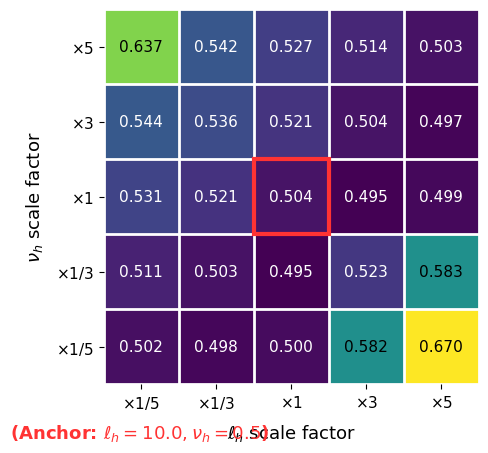

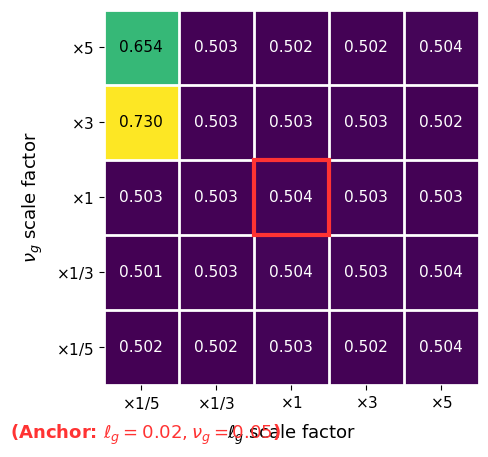

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- 설정 ---
metric_key_common = 'ls' 

# --- Helper Functions (동일) ---
def _fmt_ratio(v):
    if np.isclose(v, 0.2): return r'$\times 1/5$'
    if np.isclose(v, 1/3): return r'$\times 1/3$'
    if np.isclose(v, 1.0): return r'$\times 1$'
    if np.isclose(v, 3.0): return r'$\times 3$'
    if np.isclose(v, 5.0): return r'$\times 5$'
    return fr'$\times {v:g}$'

def _plot_vr_heatmap(results, anchor_ell, anchor_nu, x_key, y_key, 
                     xlabel, ylabel, output_filename=None):
    if not results:
        print(f"No results found.")
        return

    # 1. Data Parsing
    rows = []
    for r in results:
        try:
            val = float(r.get(metric_key_common))
            if np.isfinite(val):
                rows.append({
                    'ell_ratio': float(r[x_key]) / anchor_ell,
                    'nu_ratio': float(r[y_key]) / anchor_nu,
                    'val': val
                })
        except: continue
            
    if not rows: return

    # 2. Grid Construction
    xs = sorted({r['ell_ratio'] for r in rows})
    ys = sorted({r['nu_ratio'] for r in rows})
    Z = np.full((len(ys), len(xs)), np.nan)
    
    for r in rows:
        xi = xs.index(r['ell_ratio'])
        yi = ys.index(r['nu_ratio'])
        Z[yi, xi] = r['val']

    # 3. Plotting
    # 텍스트가 밖으로 나가므로 하단 여백 확보를 위해 figsize 조정 가능
    fig, ax = plt.subplots(figsize=(5, 5)) 
    
    im = ax.imshow(Z, cmap='viridis', origin='lower', aspect='equal')

    # 4. Annotations
    min_val, max_val = np.nanmin(Z), np.nanmax(Z)
    for i in range(len(ys)):
        for j in range(len(xs)):
            val = Z[i, j]
            if np.isnan(val): continue
            norm_val = (val - min_val) / (max_val - min_val) if max_val > min_val else 0.5
            text_color = 'white' if norm_val < 0.4 else 'black'
            ax.text(j, i, f"{val:.3f}", ha='center', va='center', 
                    color=text_color, fontsize=11, fontweight='medium')

    # 5. Anchor Highlight
    try:
        idx_x = next(i for i, x in enumerate(xs) if np.isclose(x, 1.0))
        idx_y = next(i for i, y in enumerate(ys) if np.isclose(y, 1.0))
        rect = patches.Rectangle((idx_x - 0.5, idx_y - 0.5), 1, 1, 
                                 linewidth=3, edgecolor='#ff3333', facecolor='none', zorder=10)
        ax.add_patch(rect)
    except: pass

    # 6. Formatting
    ax.set_xticks(np.arange(len(xs)))
    ax.set_yticks(np.arange(len(ys)))
    ax.set_xticklabels([_fmt_ratio(x) for x in xs], fontsize=11)
    ax.set_yticklabels([_fmt_ratio(y) for y in ys], fontsize=11)
    
    ax.set_xlabel(xlabel, fontsize=13, labelpad=8)
    ax.set_ylabel(ylabel, fontsize=13, labelpad=8)
    
    # === 🚀 [수정됨] Anchor 정보 (좌측 하단 외부) ===
    sym_ell = xlabel.split(' ')[0].replace('$', '')
    sym_nu  = ylabel.split(' ')[0].replace('$', '')
    
    subtitle = rf"(Anchor: ${sym_ell}={anchor_ell}, {sym_nu}={anchor_nu}$)"
    
    # transform=ax.transAxes 기준 (0,0)은 플랏의 좌하단 꼭짓점
    # (-0.2, -0.2) 정도면 축 레이블 바깥쪽 대각선 방향입니다.
    # 위치가 마음에 안 들면 x, y 값을 조금씩 조절하세요.
    ax.text(-0.25, -0.1, subtitle, transform=ax.transAxes, 
            ha='left', va='top', fontsize=13, 
            color='#ff3333', fontweight='bold')
    # =======================================

    # Grid & Spines
    ax.set_xticks(np.arange(len(xs)+1)-0.5, minor=True)
    ax.set_yticks(np.arange(len(ys)+1)-0.5, minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', bottom=False, left=False)
    for spine in ax.spines.values(): spine.set_visible(False)

    plt.tight_layout()
    # 텍스트가 플랏 영역 밖으로 나갔으므로 bbox_inches='tight'가 필수입니다.
    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    plt.show()

# --- 실행 ---
if results_h_stage2_exp and anchor_h_exp:
    _plot_vr_heatmap(
        results_h_stage2_exp,
        anchor_ell=float(anchor_h_exp['ell_h']),
        anchor_nu=float(anchor_h_exp['nu_h']),
        x_key='ell_h', y_key='nu_h',
        xlabel=r'$\ell_h$ scale factor',
        ylabel=r'$\nu_h$ scale factor',
        output_filename=f"fig/{foldername}/heatmap_h_vr.pdf"
    )

if results_g_stage2_exp and anchor_g_se:
    _plot_vr_heatmap(
        results_g_stage2_exp,
        anchor_ell=float(anchor_g_se['ell_g']),
        anchor_nu=float(anchor_g_se['nu_g']),
        x_key='ell_g', y_key='nu_g',
        xlabel=r'$\ell_g$ scale factor',
        ylabel=r'$\nu_g$ scale factor',
        output_filename=f"fig/{foldername}/heatmap_g_vr.pdf"
    )

In [47]:
# --- 수정된 함수 (달러 기호 중복 방지 적용) ---
def _plot_combined_sensitivity(results, anchor_ell, anchor_nu, x_key, y_key, 
                               title_main, xlabel, ylabel):
    rows = _process_data(results, x_key, y_key, anchor_ell, anchor_nu)
    if not rows:
        print(f"No data for {title_main}")
        return

    xs = sorted({r['r_ell'] for r in rows})
    ys = sorted({r['r_nu'] for r in rows})
    Z = np.full((len(ys), len(xs)), np.nan)
    
    for r in rows:
        xi = xs.index(r['r_ell'])
        yi = ys.index(r['r_nu'])
        Z[yi, xi] = r['val']

    fig, (ax_hm, ax_ln) = plt.subplots(2, 1, figsize=(6, 9.5), 
                                       gridspec_kw={'height_ratios': [1, 0.8], 'hspace': 0.4})

    # === [Top] Tabular Heatmap ===
    im = ax_hm.imshow(Z, cmap='viridis', origin='lower', aspect='auto')
    
    min_val, max_val = np.nanmin(Z), np.nanmax(Z)
    for i in range(len(ys)):
        for j in range(len(xs)):
            val = Z[i, j]
            if np.isnan(val): continue
            norm_val = (val - min_val) / (max_val - min_val) if max_val > min_val else 0.5
            text_color = 'white' if norm_val < 0.4 else 'black'
            ax_hm.text(j, i, f"{val:.3f}", ha='center', va='center', 
                       color=text_color, fontsize=10, fontweight='medium')

    try:
        idx_x = next(i for i, x in enumerate(xs) if np.isclose(x, 1.0))
        idx_y = next(i for i, y in enumerate(ys) if np.isclose(y, 1.0))
        rect = patches.Rectangle((idx_x - 0.5, idx_y - 0.5), 1, 1, 
                                 linewidth=3, edgecolor='#ff3333', facecolor='none', zorder=10)
        ax_hm.add_patch(rect)
    except: pass

    ax_hm.set_xticks(range(len(xs)))
    ax_hm.set_xticklabels([_fmt_ratio(x) for x in xs], fontsize=11)
    ax_hm.set_yticks(range(len(ys)))
    ax_hm.set_yticklabels([_fmt_ratio(y) for y in ys], fontsize=11)
    
    # === [핵심 수정 부분] ===
    # Main Title
    ax_hm.text(0.5, 1.12, METRIC_LABEL, transform=ax_hm.transAxes, 
               ha='center', va='bottom', fontsize=13, fontweight='bold')
    
    # Subtitle: 기존 라벨에서 $ 기호를 제거(.replace)한 뒤 다시 포맷팅합니다.
    # 예: "$\ell_h$ scale" -> "\ell_h" -> "Anchor: $\ell_h=...$"
    symbol_ell = xlabel.split(' ')[0].replace('$', '')
    symbol_nu = ylabel.split(' ')[0].replace('$', '')
    
    subtitle = rf"Anchor: ${symbol_ell}={anchor_ell}, {symbol_nu}={anchor_nu}$"
    
    ax_hm.text(0.5, 1.05, subtitle, transform=ax_hm.transAxes, 
               ha='center', va='bottom', fontsize=11, color='#333333')
    # ======================

    ax_hm.set_ylabel(ylabel, fontsize=12)

    # === [Bottom] Line Plot ===
    colors = plt.cm.viridis(np.linspace(0, 1, len(ys)))
    
    for i, y_ratio in enumerate(ys):
        subset = sorted([r for r in rows if np.isclose(r['r_nu'], y_ratio)], key=lambda x: x['r_ell'])
        if not subset: continue
        
        line_xs = [r['r_ell'] for r in subset]
        line_vals = [r['val'] for r in subset]
        
        if np.isclose(y_ratio, 1.0):
            style = {'color': '#ff3333', 'lw': 2.5, 'ls': '-', 'zorder': 10}
            label = r"Anchor ($\times 1$)"
        else:
            style = {'color': colors[i], 'lw': 1.5, 'ls': '--', 'alpha': 0.8}
            label = _fmt_ratio(y_ratio)
            
        ax_ln.plot(line_xs, line_vals, marker='o', markersize=5, **style, label=label)

    ax_ln.set_xscale('log')
    ax_ln.set_xticks(xs)
    ax_ln.set_xticklabels([_fmt_ratio(x) for x in xs], fontsize=11)
    ax_ln.minorticks_off()
    
    ax_ln.set_xlabel(xlabel, fontsize=12)
    ax_ln.set_ylabel("Variance Ratio", fontsize=12)
    ax_ln.grid(True, linestyle=':', alpha=0.6)
    
    # 범례 타이틀에서도 $ 제거하여 깔끔하게 표시
    legend_title = ylabel.split(' ')[0].replace('$', '')
    legend = ax_ln.legend(title=f"${legend_title}$", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
    legend.get_title().set_fontsize(11)

    plt.tight_layout()
    plt.show()

NameError: name '_sorted_unique' is not defined

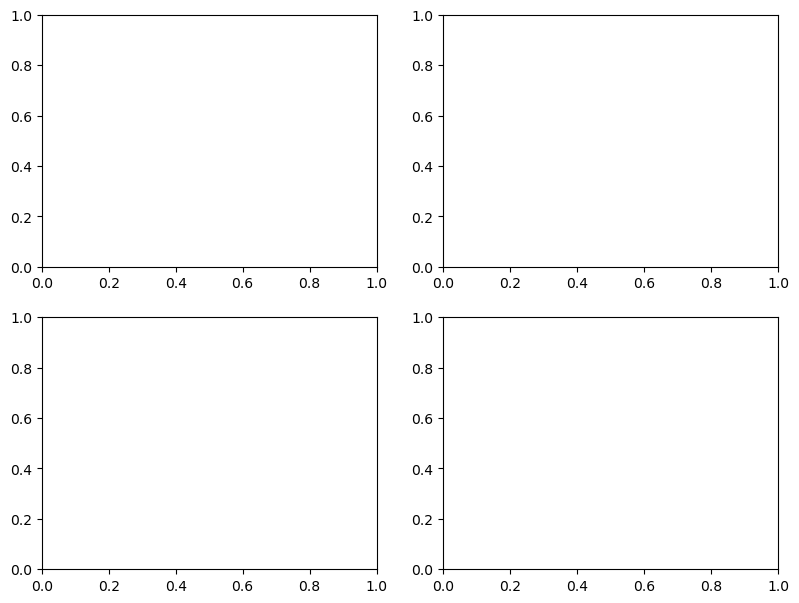

In [46]:
# --- Stage 2 acceptance heatmaps (SE + EXP) ---


# Only EXP stage2 (hide SE plots)


ONLY_EXP_STAGE2 = globals().get('ONLY_EXP_STAGE2', False)
if ONLY_EXP_STAGE2:
    results_h_stage2_se = []
    results_g_stage2_se = []

def _acc_grid(results, x_key, y_key, metric_key):
    xs = _sorted_unique([r.get(x_key) for r in results])
    ys = _sorted_unique([r.get(y_key) for r in results])
    grid = _grid_from_results(results, x_key, y_key, metric_key)
    Z = np.full((len(ys), len(xs)), np.nan)
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            v = grid.get((y, x), np.nan)
            if np.isfinite(v):
                Z[i, j] = v
    return xs, ys, Z

def _collect_acc_vals(results_list):
    vals = []
    for results in results_list:
        for r in results:
            for k in ('acc_h_mean', 'acc_g_mean'):
                v = r.get(k)
                try:
                    v = float(v)
                except Exception:
                    continue
                if np.isfinite(v):
                    vals.append(v)
    return vals

def _kernel_label(results):
    if not results:
        return 'h=?, g=?'
    r0 = results[0]
    kh = r0.get('cov_kernel_h', '?')
    kg = r0.get('cov_kernel_g', '?')
    return f"h={kh}, g={kg}"

_acc_vals = _collect_acc_vals([results_h_stage2_se, results_g_stage2_se, results_h_stage2_exp, results_g_stage2_exp])
if _acc_vals:
    ACC_VMIN = float(np.nanmin(_acc_vals))
    ACC_VMAX = float(np.nanmax(_acc_vals))
else:
    ACC_VMIN = 0.0
    ACC_VMAX = 1.0

def _plot_acc_subplots(results_h, results_g, label):
    fig, axes = plt.subplots(2, 2, figsize=(9.5, 7.2), sharex=False, sharey=False)
    entries = [
        (results_h, 'ell_h', 'nu_h', 'acc_h_mean', 'h-sweep acc_h'),
        (results_h, 'ell_h', 'nu_h', 'acc_g_mean', 'h-sweep acc_g'),
        (results_g, 'ell_g', 'nu_g', 'acc_h_mean', 'g-sweep acc_h'),
        (results_g, 'ell_g', 'nu_g', 'acc_g_mean', 'g-sweep acc_g'),
    ]
    for ax, (results, x_key, y_key, metric_key, title) in zip(axes.ravel(), entries):
        if not results:
            ax.axis('off')
            continue
        xs, ys, Z = _acc_grid(results, x_key, y_key, metric_key)
        ax.imshow(Z, origin='lower', aspect='auto', vmin=ACC_VMIN, vmax=ACC_VMAX)
        ax.set_xticks(range(len(xs)))
        ax.set_xticklabels([f"{x:.3g}" for x in xs], rotation=45)
        ax.set_yticks(range(len(ys)))
        ax.set_yticklabels([f"{y:.3g}" for y in ys])
        ax.set_xlabel(x_key)
        ax.set_ylabel(y_key)
        ax.set_title(f"{title} ({label}, {_kernel_label(results)})")
        # Overlay acc values with background for legibility
        for i, y in enumerate(ys):
            for j, x in enumerate(xs):
                v = Z[i, j]
                if np.isfinite(v):
                    ax.text(
                        j, i, f"{v:.3f}", ha='center', va='center', fontsize=7, color='black',
                        bbox=dict(boxstyle='round,pad=0.15', facecolor='white', alpha=0.7, edgecolor='none')
                    )
    fig.suptitle(f"Acceptance heatmaps ({label}, {_kernel_label(results_h or results_g)})")
    plt.tight_layout()
    plt.show()

if results_h_stage2_se or results_g_stage2_se:
    _plot_acc_subplots(results_h_stage2_se, results_g_stage2_se, 'SE')
if results_h_stage2_exp or results_g_stage2_exp:
    _plot_acc_subplots(results_h_stage2_exp, results_g_stage2_exp, 'EXP')

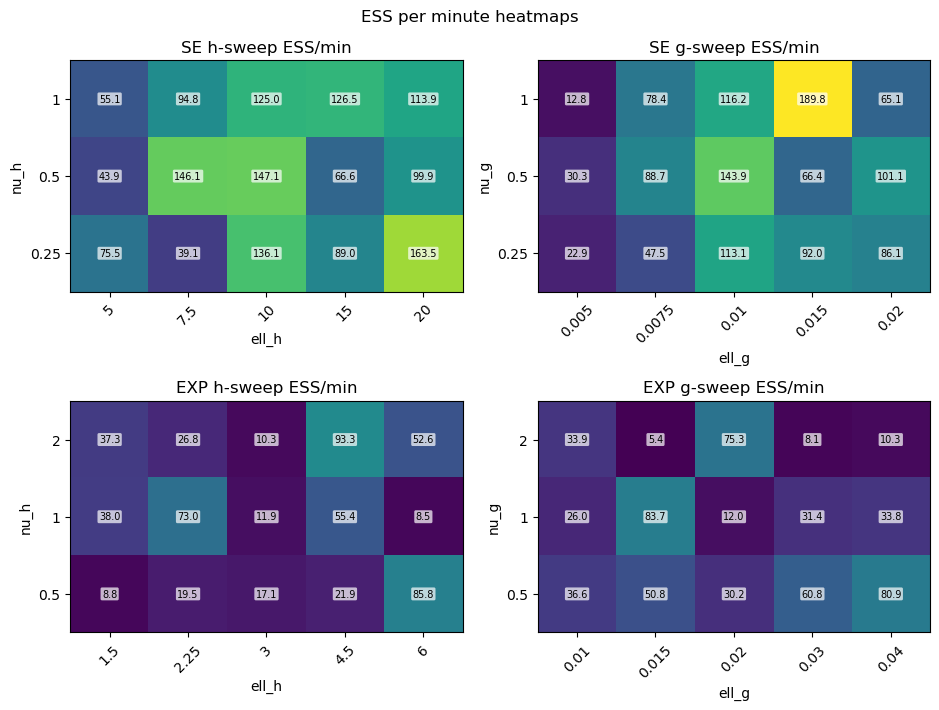

In [ ]:
# --- Stage 2 ESS per minute heatmaps (SE + EXP) ---


# Only EXP stage2 (hide SE plots)


ONLY_EXP_STAGE2 = globals().get('ONLY_EXP_STAGE2', False)
if ONLY_EXP_STAGE2:
    results_h_stage2_se = []
    results_g_stage2_se = []

def _ess_per_min(row):
    v = row.get('ess_per_min', None)
    try:
        v = float(v) if v is not None else None
    except Exception:
        v = None
    if v is not None and np.isfinite(v):
        return v
    # fallback: ess_g_mid / elapsed_sec * 60
    try:
        ess = float(row.get('ess_g_mid'))
        elapsed = float(row.get('elapsed_sec'))
    except Exception:
        return np.nan
    if not np.isfinite(ess) or not np.isfinite(elapsed) or elapsed <= 0:
        return np.nan
    return ess / elapsed * 60.0

def _ess_grid(results, x_key, y_key):
    xs = _sorted_unique([r.get(x_key) for r in results])
    ys = _sorted_unique([r.get(y_key) for r in results])
    grid = {}
    for r in results:
        try:
            x = float(r.get(x_key))
            y = float(r.get(y_key))
        except Exception:
            continue
        grid[(y, x)] = _ess_per_min(r)
    Z = np.full((len(ys), len(xs)), np.nan)
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            v = grid.get((y, x), np.nan)
            if np.isfinite(v):
                Z[i, j] = v
    return xs, ys, Z

def _collect_ess_vals(results_list):
    vals = []
    for results in results_list:
        for r in results:
            v = _ess_per_min(r)
            if np.isfinite(v):
                vals.append(v)
    return vals

_ess_vals = _collect_ess_vals([results_h_stage2_se, results_g_stage2_se, results_h_stage2_exp, results_g_stage2_exp])
if _ess_vals:
    ESS_VMIN = float(np.nanmin(_ess_vals))
    ESS_VMAX = float(np.nanmax(_ess_vals))
else:
    ESS_VMIN = 0.0
    ESS_VMAX = 1.0

def _plot_ess_2x2():
    fig, axes = plt.subplots(2, 2, figsize=(9.5, 7.2), sharex=False, sharey=False)
    entries = [
        (results_h_stage2_se, 'ell_h', 'nu_h', 'SE h-sweep'),
        (results_g_stage2_se, 'ell_g', 'nu_g', 'SE g-sweep'),
        (results_h_stage2_exp, 'ell_h', 'nu_h', 'EXP h-sweep'),
        (results_g_stage2_exp, 'ell_g', 'nu_g', 'EXP g-sweep'),
    ]
    for ax, (results, x_key, y_key, title) in zip(axes.ravel(), entries):
        if not results:
            ax.axis('off')
            continue
        xs, ys, Z = _ess_grid(results, x_key, y_key)
        ax.imshow(Z, origin='lower', aspect='auto', vmin=ESS_VMIN, vmax=ESS_VMAX)
        ax.set_xticks(range(len(xs)))
        ax.set_xticklabels([f"{x:.3g}" for x in xs], rotation=45)
        ax.set_yticks(range(len(ys)))
        ax.set_yticklabels([f"{y:.3g}" for y in ys])
        ax.set_xlabel(x_key)
        ax.set_ylabel(y_key)
        ax.set_title(f"{title} ESS/min")
        # Overlay ESS/min values with background for legibility
        for ii, yy in enumerate(ys):
            for jj, xx in enumerate(xs):
                vv = Z[ii, jj]
                if np.isfinite(vv):
                    ax.text(
                        jj, ii, f"{vv:.1f}", ha='center', va='center', fontsize=7, color='black',
                        bbox=dict(boxstyle='round,pad=0.15', facecolor='white', alpha=0.7, edgecolor='none')
                    )
    fig.suptitle('ESS per minute heatmaps')
    plt.tight_layout()
    plt.show()

_plot_ess_2x2()

In [ ]:
# --- ArviZ ESS diagnostics (bulk/tail) + R-hat (single-chain placeholder) ---

# Only EXP stage2 (hide SE plots)


ONLY_EXP_STAGE2 = globals().get('ONLY_EXP_STAGE2', False)
if ONLY_EXP_STAGE2:
    results_h_stage2_se = []
    results_g_stage2_se = []

def _summarize_arviz_ess(results, label):
    rows = []
    for r in results:
        rows.append({
            'case': r.get('label', ''),
            'sigma_mult': r.get('sigma_mult', None),
            'ess_g_q25_bulk': r.get('ess_g_q25_bulk'),
            'ess_g_q25_tail': r.get('ess_g_q25_tail'),
            'ess_g_q50_bulk': r.get('ess_g_q50_bulk'),
            'ess_g_q50_tail': r.get('ess_g_q50_tail'),
            'ess_g_q75_bulk': r.get('ess_g_q75_bulk'),
            'ess_g_q75_tail': r.get('ess_g_q75_tail'),
            'ess_gamma_mid_bulk': r.get('ess_gamma_mid_bulk'),
            'ess_gamma_mid_tail': r.get('ess_gamma_mid_tail'),
            'ess_gamma_l2_bulk': r.get('ess_gamma_l2_bulk'),
            'ess_gamma_l2_tail': r.get('ess_gamma_l2_tail'),
            'ess_c_mean_bulk': r.get('ess_c_mean_bulk'),
            'ess_c_mean_tail': r.get('ess_c_mean_tail'),
            'ess_a_mean_bulk': r.get('ess_a_mean_bulk'),
            'ess_a_mean_tail': r.get('ess_a_mean_tail'),
            'ess_alpha_bulk': r.get('ess_alpha_bulk'),
            'ess_alpha_tail': r.get('ess_alpha_tail'),
            # R-hat placeholder (single-chain -> NaN)
            'rhat_placeholder': float('nan'),
        })
    if not rows:
        return None
    try:
        import pandas as pd
        df = pd.DataFrame(rows)
        df = df.sort_values(['case', 'sigma_mult'], na_position='last')
        display(df)
    except Exception:
        for rr in rows:
            print(rr)
    return rows

# Stage2 results
_ = _summarize_arviz_ess(results_h_stage2_se + results_g_stage2_se, 'SE stage2') if (results_h_stage2_se or results_g_stage2_se) else None
_ = _summarize_arviz_ess(results_h_stage2_exp + results_g_stage2_exp, 'EXP stage2') if (results_h_stage2_exp or results_g_stage2_exp) else None

# Sigma-only sweep results (if present)
if 'results_sigma_se' in globals() and results_sigma_se:
    _ = _summarize_arviz_ess(results_sigma_se, 'sigma SE')
if 'results_sigma_exp' in globals() and results_sigma_exp:
    _ = _summarize_arviz_ess(results_sigma_exp, 'sigma EXP')

,case,sigma_mult,ess_g_q25_bulk,ess_g_q25_tail,ess_g_q50_bulk,ess_g_q50_tail,ess_g_q75_bulk,ess_g_q75_tail,ess_gamma_mid_bulk,ess_gamma_mid_tail,ess_gamma_l2_bulk,ess_gamma_l2_tail,ess_c_mean_bulk,ess_c_mean_tail,ess_a_mean_bulk,ess_a_mean_tail,ess_alpha_bulk,ess_alpha_tail,rhat_placeholder
15,"g(se): ell_g=0.005 (0.5x), nu_g=0.25 (0.5x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
16,"g(se): ell_g=0.005 (0.5x), nu_g=0.5 (1.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
17,"g(se): ell_g=0.005 (0.5x), nu_g=1 (2.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
19,"g(se): ell_g=0.0075 (0.75x), nu_g=0.25 (0.5x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
18,"g(se): ell_g=0.0075 (0.75x), nu_g=0.5 (1.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
20,"g(se): ell_g=0.0075 (0.75x), nu_g=1 (2.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
21,"g(se): ell_g=0.01 (1.0x), nu_g=0.25 (0.5x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
24,"g(se): ell_g=0.01 (1.0x), nu_g=0.5 (1.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
22,"g(se): ell_g=0.01 (1.0x), nu_g=1 (2.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
23,"g(se): ell_g=0.015 (1.5x), nu_g=0.25 (0.5x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN


,case,sigma_mult,ess_g_q25_bulk,ess_g_q25_tail,ess_g_q50_bulk,ess_g_q50_tail,ess_g_q75_bulk,ess_g_q75_tail,ess_gamma_mid_bulk,ess_gamma_mid_tail,ess_gamma_l2_bulk,ess_gamma_l2_tail,ess_c_mean_bulk,ess_c_mean_tail,ess_a_mean_bulk,ess_a_mean_tail,ess_alpha_bulk,ess_alpha_tail,rhat_placeholder
15,"g(exp): ell_g=0.01 (0.5x), nu_g=0.5 (0.5x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
17,"g(exp): ell_g=0.01 (0.5x), nu_g=1 (1.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
16,"g(exp): ell_g=0.01 (0.5x), nu_g=2 (2.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
18,"g(exp): ell_g=0.015 (0.75x), nu_g=0.5 (0.5x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
22,"g(exp): ell_g=0.015 (0.75x), nu_g=1 (1.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
19,"g(exp): ell_g=0.015 (0.75x), nu_g=2 (2.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
20,"g(exp): ell_g=0.02 (1.0x), nu_g=0.5 (0.5x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
21,"g(exp): ell_g=0.02 (1.0x), nu_g=1 (1.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
23,"g(exp): ell_g=0.02 (1.0x), nu_g=2 (2.0x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
24,"g(exp): ell_g=0.03 (1.5x), nu_g=0.5 (0.5x)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN


In [ ]:
# --- Sigma-only ArviZ ESS plots (bulk/tail) ---
import numpy as np
import matplotlib.pyplot as plt

def _plot_sigma_arviz(results, label):
    if not results:
        return
    # sort by sigma multiplier
    rows = sorted(results, key=lambda r: r.get('sigma_mult', 1.0))
    sigmas = [r.get('sigma_mult', 1.0) for r in rows]
    # pick a few representative ArviZ ESS metrics
    metrics = [
        ('ess_g_q50_bulk', 'g(t50) bulk'),
        ('ess_g_q50_tail', 'g(t50) tail'),
        ('ess_gamma_mid_bulk', 'gamma_mid bulk'),
        ('ess_gamma_mid_tail', 'gamma_mid tail'),
        ('ess_c_mean_bulk', 'mean_c bulk'),
        ('ess_a_mean_bulk', 'mean_a bulk'),
        ('ess_alpha_bulk', 'alpha bulk'),
    ]

    fig, axes = plt.subplots(2, 4, figsize=(12, 5), sharex=True)
    axes = axes.ravel()
    for ax, (key, title) in zip(axes, metrics):
        vals = [r.get(key, np.nan) for r in rows]
        ax.plot(sigmas, vals, marker='o')
        ax.set_title(title)
        ax.set_xlabel('sigma multiplier')
        ax.set_ylabel('ESS')
    # hide unused axes if any
    for j in range(len(metrics), len(axes)):
        axes[j].axis('off')
    fig.suptitle(f'ArviZ ESS (sigma-only) - {label}')
    plt.tight_layout()
    plt.show()

if 'results_sigma_se' in globals() and results_sigma_se:
    _plot_sigma_arviz(results_sigma_se, 'SE')
if 'results_sigma_exp' in globals() and results_sigma_exp:
    _plot_sigma_arviz(results_sigma_exp, 'EXP')



sigma-only anchors (SE): {'s2y': 0.2, 'cov_kernel_h': 'se', 'nu_h': 0.5, 'ell_h': 10.0, 'cov_kernel_g': 'se', 'nu_g': 1.0, 'ell_g': 0.01, 'c_hyper': {'shape': 10.0, 'scale': 0.1}, 'a_hyper': {'mean': 0, 'var': 1000}, 'beta_h_choices': array([0.03, 0.05, 0.07, 0.1 , 0.14, 0.2 , 0.28, 0.35, 0.45]), 'beta_g_choices': array([0.002, 0.003, 0.005, 0.01 , 0.02 , 0.035, 0.05 , 0.07 , 0.1  ]), 'verbose': False, 'beta_adapt': True, 'beta_n_adapt': 2000, 'beta_window': 50, 'beta_acc_target_h': 0.25, 'beta_acc_target_g': 0.25, 'beta_c_h': 0.15, 'beta_c_g': 0.15, 'beta_fixed': 0.35, 'beta_h_fixed_prob': 0.05, 'beta_g_fixed_prob': 0.0, 'label': 'h(se): ell_h=10.0, nu_h=0.5', 'g_nrmse': 0.08627227889819832, 'g_nrmse_raw': 0.08627227889819832, 'gamma_ci_width': 0.03706324201231367, 'ls': 0.5042721371837069, 'pc': 2.5310500205670072, 'acc_h_mean': 0.2889900000000001, 'acc_g_mean': 0.2578, 'acc_c_mean': 0.7713800000000001, 'ess_g_mid': 63.71338788053694, 'ess_gamma_mid': 158.5178716346623, 'ess_c_mean':

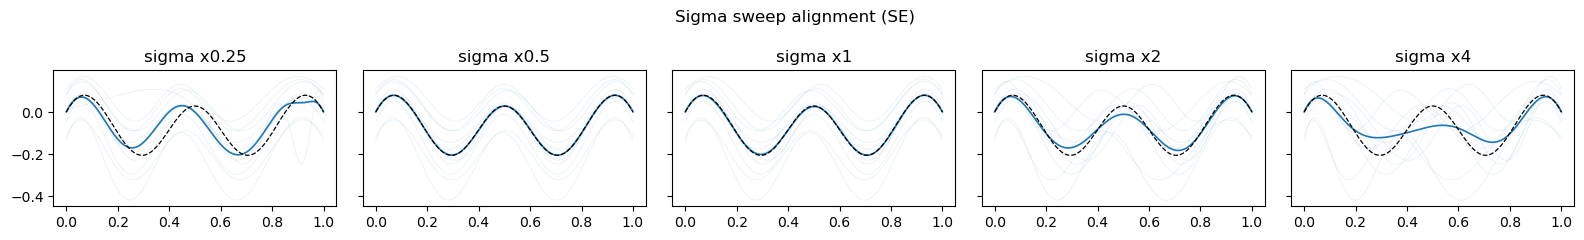

[sigma-exp] 2/5[sigma-exp] 1/5

[sigma-exp] 3/5
[sigma-exp] 4/5
[sigma-exp] 5/5
[logs] merged -> fig/section2_4_1_st_v3/logs/sigma_exp_merged.txt



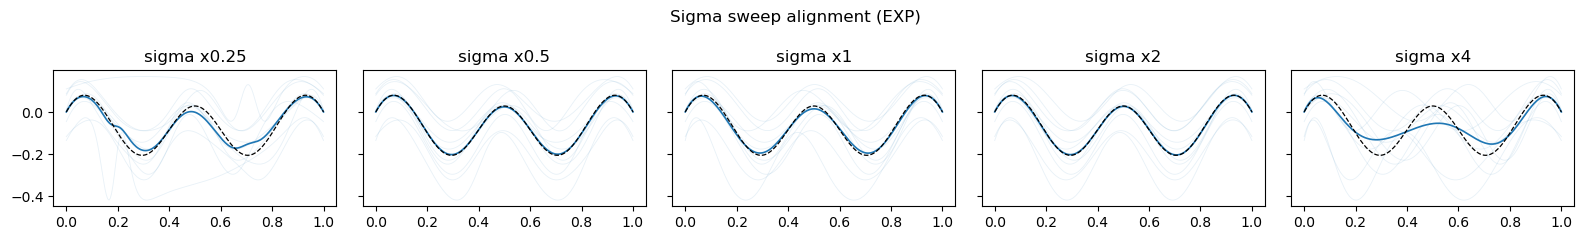

,case,sigma_mult,s2y,acc_h_mean,acc_g_mean,acc_c_mean,ess_alpha,ess_c_mean,ess_a_mean,ess_g_t25,ess_g_t50,ess_g_t75,ess_g_median_t,ess_g_mid,ess_per_min
5,sigma=0.25x (exp),0.25,0.05,None,None,None,None,None,None,None,None,None,None,None,None
3,sigma=0.25x (se),0.25,0.05,None,None,None,None,None,None,None,None,None,None,None,None
6,sigma=0.5x (exp),0.50,0.10,None,None,None,None,None,None,None,None,None,None,None,None
0,sigma=0.5x (se),0.50,0.10,None,None,None,None,None,None,None,None,None,None,None,None
7,sigma=1x (exp),1.00,0.20,None,None,None,None,None,None,None,None,None,None,None,None
2,sigma=1x (se),1.00,0.20,None,None,None,None,None,None,None,None,None,None,None,None
8,sigma=2x (exp),2.00,0.40,None,None,None,None,None,None,None,None,None,None,None,None
1,sigma=2x (se),2.00,0.40,None,None,None,None,None,None,None,None,None,None,None,None
9,sigma=4x (exp),4.00,0.80,None,None,None,None,None,None,None,None,None,None,None,None
4,sigma=4x (se),4.00,0.80,None,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
# --- Sigma-only sweep around anchors (SE + EXP) ---
import numpy as np
from pathlib import Path
import time

sigma_multipliers = [1/4, 1/2, 1.0, 2.0, 4.0]
base_s2y = float(s2y)
if 'keep_last' not in globals():
    keep_last = 0  # use full post-burn chain
data_dict_sigma = dict(data_dict)
data_dict_sigma.pop('s2y', None)

cache_dir_sigma = Path(f"fig/{foldername}") / "cache_stage2_sigma"
cache_dir_sigma.mkdir(parents=True, exist_ok=True)

import multiprocessing as _mp
_MP_CTX = _mp.get_context('fork')
_MP_WORKERS = 4

def _run_sigma_cfg(*args):
    if len(args) == 1 and isinstance(args[0], tuple):
        cfg, cache_dir, label, mult, idx, total, log_path = args[0]
    else:
        cfg, cache_dir, label, mult, idx, total, log_path = args
    cache_params = dict(cfg)
    for key in ('beta_h_choices', 'beta_g_choices'):
        if key in cache_params:
            try:
                cache_params[key] = list(cache_params[key])
            except Exception:
                pass
    for k, v in list(cache_params.items()):
        try:
            if hasattr(v, 'tolist'):
                cache_params[k] = v.tolist()
        except Exception:
            pass
    cache_params.update({
        'cache_tag': str(cache_tag),
        'K_sens': int(K_sens),
        'keep_last': int(keep_last),
        'seed': int(seed),
        'burn_iter': int(burn_iter),
        'algo': 'alg3_v2',
        'stage': 'sens',
        'sweep': 'sigma_only',
        'sigma_mult': float(mult),
    })
    cache_key = make_cache_key(cache_params, y, t)
    cache_path = cache_dir / f"sigma_{label}_{cache_key}.npz"
    row = None
    if cache_path.exists():
        cache = load_cache(cache_path)
        if cache is not None:
            arrays = cache['arrays']
            row = {'cache_path': str(cache_path)}
            gamma_mean = arrays.get('_gamma_mean') if '_gamma_mean' in arrays else arrays.get('gamma_mean')
            if gamma_mean is not None:
                row['gamma_mean'] = gamma_mean
    if row is None:
        start_time = time.time()
        with open(log_path, "w") as lf:
            with contextlib.redirect_stdout(lf):
                row = validation.run_pmcmc_sensitivity(
            cfg,
            K_sens=K_sens,
            keep_last=keep_last,
            seed=seed,
            collect_summaries=True,
            burn_frac=(burn_iter / float(K_sens)),
                    data=data_dict_sigma,
                            )
        summary_keys = (
            '_gamma_mean', '_gamma_ci_lower', '_gamma_ci_upper',
        )
        summary = {k: row.pop(k) for k in summary_keys if k in row}
        if summary:
            save_cache(cache_path, cache_params, summary)
        row['elapsed_sec'] = float(time.time() - start_time)
    row_full = dict(cfg)
    row_full.update(row)
    row_full['sigma_mult'] = float(mult)
    row_full['cache_path'] = str(cache_path)
    if idx is not None and total is not None:
        if (idx + 1) % max(1, total // 10) == 0 or (idx + 1) == total:
            print(f"[sigma-{label}] {idx+1}/{total}")
    return row_full

from pathlib import Path
import contextlib
import io
LOG_DIR = Path(f"fig/{foldername}") / 'logs'
LOG_DIR.mkdir(parents=True, exist_ok=True)

def _merge_logs(tag, log_paths):
    if not log_paths:
        return
    merged_path = LOG_DIR / f"{tag}_merged.txt"
    with open(merged_path, 'w') as mf:
        for p in log_paths:
            if not p.exists():
                continue
            mf.write(f"===== {p.name} =====\n")
            mf.write(p.read_text())
            mf.write('\n')
    print(f"[logs] merged -> {merged_path}")
    print(merged_path.read_text())
    for p in log_paths:
        try:
            p.unlink()
        except Exception:
            pass

def _run_sigma_sweep(anchor_h, anchor_g, label):
    results = []
    cfgs = []
    for mult in sigma_multipliers:
        cfg = {
            's2y': base_s2y * float(mult),
            'cov_kernel_h': anchor_h['cov_kernel_h'],
            'nu_h': anchor_h['nu_h'],
            'ell_h': anchor_h['ell_h'],
            'cov_kernel_g': anchor_g['cov_kernel_g'],
            'nu_g': anchor_g['nu_g'],
            'ell_g': anchor_g['ell_g'],
            'c_hyper': c_hyper,
            'a_hyper': a_hyper,
            'beta_h_choices': beta_h_choices,
            'beta_g_choices': beta_g_choices,
            'beta_adapt': beta_adapt,
            'beta_n_adapt': beta_n_adapt,
            'beta_window': beta_window,
            'beta_acc_target_h': beta_acc_target_h,
            'beta_acc_target_g': beta_acc_target_g,
            'beta_c_h': beta_c_h,
            'beta_c_g': beta_c_g,
            'beta_fixed': beta_fixed,
            'beta_h_fixed_prob': beta_h_fixed_prob,
            'beta_g_fixed_prob': beta_g_fixed_prob,
            'label': f"sigma={mult:.3g}x ({label})",
        }
        cfgs.append((cfg, mult))
    total = len(cfgs)
    log_paths = []
    args = []
    for i in range(total):
        lp = LOG_DIR / f"sigma_{label}_{i}.txt"
        log_paths.append(lp)
        args.append((cfgs[i][0], cache_dir_sigma, label, cfgs[i][1], i, total, lp))
    try:
        with _MP_CTX.Pool(processes=_MP_WORKERS) as pool:
            for row_full in pool.imap_unordered(_run_sigma_cfg, args):
                results.append(row_full)
    except Exception as e:
        print(f"[mp] fallback to serial due to: {e}")
        for i, (cfg, mult) in enumerate(cfgs):
            row_full = _run_sigma_cfg((cfg, cache_dir_sigma, label, mult, i, total, log_paths[i]))
            results.append(row_full)
    _merge_logs(f"sigma_{label}", log_paths)
    return results
def _plot_sigma_alignment(results, title):
    if not results:
        return
    results = sorted(results, key=lambda r: r.get('sigma_mult', 1.0))
    fig, axes = plt.subplots(1, len(results), figsize=(3.2 * len(results), 2.4), sharex=True, sharey=True)
    if len(results) == 1:
        axes = [axes]
    for ax, r in zip(axes, results):
        cache_path = r.get('cache_path')
        gamma_mean = None
        if cache_path and Path(cache_path).exists():
            cache = load_cache(cache_path)
            if cache is not None:
                arrays = cache.get('arrays', {})
                gamma_mean = arrays.get('_gamma_mean') if '_gamma_mean' in arrays else arrays.get('gamma_mean')
        if gamma_mean is None:
            ax.axis('off')
            continue
        f_aligned = np.array([np.interp(gamma_mean[k], t, f_true[k]) for k in range(num_obs)])
        f_aligned_mean = np.mean(f_aligned, axis=0)
        for k in range(num_obs):
            ax.plot(t, f_aligned[k], color='tab:blue', alpha=0.1, lw=0.6)
        ax.plot(t, f_aligned_mean, color='tab:blue', lw=1.2)
        ax.plot(t, g_true, color='black', lw=0.9, ls='--')
        ax.set_title(f"sigma x{r.get('sigma_mult', 1.0):.3g}")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

print('sigma-only anchors (SE):', anchor_h_se, anchor_g_se)
print('sigma-only anchors (EXP):', anchor_h_exp, anchor_g_exp)
results_sigma_se = []
results_sigma_exp = []
if anchor_h_se is not None and anchor_g_se is not None:
    results_sigma_se = _run_sigma_sweep(anchor_h_se, anchor_g_se, 'se')
    _plot_sigma_alignment(results_sigma_se, 'Sigma sweep alignment (SE)')
if anchor_h_exp is not None and anchor_g_exp is not None:
    results_sigma_exp = _run_sigma_sweep(anchor_h_exp, anchor_g_exp, 'exp')
    _plot_sigma_alignment(results_sigma_exp, 'Sigma sweep alignment (EXP)')

# --- Sigma sweep summary table (ESS + acc) ---
def _row_to_summary(row):
    # Compute ess_per_min if missing
    ess_per_min = row.get('ess_per_min')
    if ess_per_min is None:
        try:
            ess = float(row.get('ess_g_mid'))
            elapsed = float(row.get('elapsed_sec'))
            if elapsed > 0:
                ess_per_min = ess / elapsed * 60.0
        except Exception:
            ess_per_min = None
    return {
        'case': row.get('label', ''),
        'sigma_mult': row.get('sigma_mult'),
        's2y': row.get('s2y'),
        'acc_h_mean': row.get('acc_h_mean'),
        'acc_g_mean': row.get('acc_g_mean'),
        'acc_c_mean': row.get('acc_c_mean'),
        'ess_alpha': row.get('ess_alpha'),
        'ess_c_mean': row.get('ess_c_mean'),
        'ess_a_mean': row.get('ess_a_mean'),
        'ess_g_t25': row.get('ess_g_t25'),
        'ess_g_t50': row.get('ess_g_t50'),
        'ess_g_t75': row.get('ess_g_t75'),
        'ess_g_median_t': row.get('ess_g_median_t'),
        'ess_g_mid': row.get('ess_g_mid'),
        'ess_per_min': ess_per_min,
    }

def _build_sigma_table(results):
    rows = []
    for r in results:
        rows.append(_row_to_summary(r))
    return rows

rows = []
if results_sigma_se:
    rows.extend(_build_sigma_table(results_sigma_se))
if results_sigma_exp:
    rows.extend(_build_sigma_table(results_sigma_exp))

if rows:
    try:
        import pandas as pd
        df = pd.DataFrame(rows)
        df = df.sort_values(['case','sigma_mult'])
        display(df)
    except Exception:
        # fallback: simple print
        for r in rows:
            print(r)







N=10, T=400: y shape=(10, 400), g_true shape=(400,)
  a_true mean=5.55e-18, std=0.081
  c_true mean=1, std=0.437


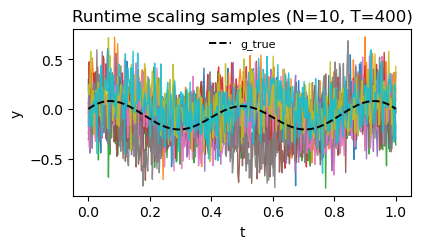

N=50, T=400: y shape=(50, 400), g_true shape=(400,)
  a_true mean=-2.08e-18, std=0.0809
  c_true mean=1, std=0.341


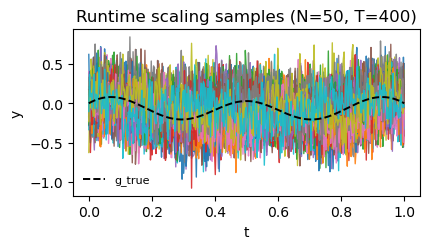

N=100, T=400: y shape=(100, 400), g_true shape=(400,)
  a_true mean=1.28e-18, std=0.101
  c_true mean=1, std=0.303


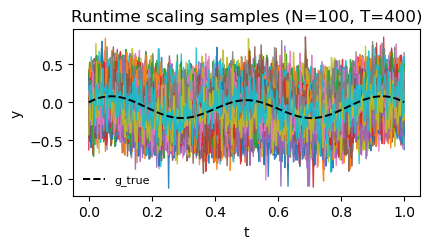

N=10000, T=400: y shape=(10000, 400), g_true shape=(400,)
  a_true mean=-1.47e-18, std=0.0993
  c_true mean=1, std=0.318


/var/folders/ts/g_tm06zs1v96ddqwmpv77zk00000gn/T/ipykernel_13890/1765301626.py:56: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/wmk/miniconda3/envs/bayes_reg/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


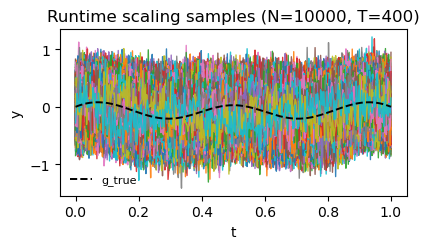

In [ ]:
# --- Preview synthetic samples used in runtime scaling ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
MODULE_DIR = Path.cwd() / 'section2.4.1'
if str(MODULE_DIR) not in sys.path:
    sys.path.append(str(MODULE_DIR))
from modeling import generate_random_warpings

# match runtime scaling generator

def _gen_data_st(num_obs, num_points, seed=2):
    np.random.seed(seed)
    t_sub = np.linspace(0, 1, num_points)
    mu1, sigma1, h1 = 0.06, 0.2, 1.5
    mu2, sigma2, h2 = 0.94, 0.2, 1.5
    mu3, sigma3, h3 = 0.5, 0.15, 1.2
    bump1 = h1 * np.exp(-((t_sub - mu1) ** 2) / (2 * sigma1**2))
    bump2 = h2 * np.exp(-((t_sub - mu2) ** 2) / (2 * sigma2**2))
    bump3 = h3 * np.exp(-((t_sub - mu3) ** 2) / (2 * sigma3**2))
    g_true_sub = bump1 + bump2 + bump3
    g_true_sub = g_true_sub - g_true_sub[0]
    gamma0_sub, _ = generate_random_warpings(t_sub, -1.5, 1.5, num_obs)
    f = np.array([np.interp(gamma0_sub[i], t_sub, g_true_sub) for i in range(num_obs)])
    sig = float(sig_y0)
    a = np.random.randn(num_obs) * 0.1
    a_true_sub = a - np.mean(a)
    c = np.random.gamma(shape=1e1, scale=1e-1, size=num_obs)
    c_true_sub = c / np.mean(c)
    f = a_true_sub[:, None] + c_true_sub[:, None] * f
    epsilon = np.random.randn(num_obs, num_points)
    epsilon -= np.mean(epsilon, axis=0)[None, :]
    y_sub = f + sig * epsilon
    return t_sub, y_sub, g_true_sub, f, gamma0_sub, a_true_sub, c_true_sub

# choose same grids as runtime scaling
obs_grid = [10, 50, 100, 10000]
T_fixed = 400

for n_obs in obs_grid:
    seed = 1000 + n_obs + T_fixed
    t_sub, y_sub, g_true_sub, f_true_sub, gamma0_sub, a_true_sub, c_true_sub = _gen_data_st(n_obs, T_fixed, seed=seed)
    print(f"N={n_obs}, T={T_fixed}: y shape={y_sub.shape}, g_true shape={g_true_sub.shape}")
    print(f"  a_true mean={a_true_sub.mean():.3g}, std={a_true_sub.std():.3g}")
    print(f"  c_true mean={c_true_sub.mean():.3g}, std={c_true_sub.std():.3g}")
    
    plt.figure(figsize=(4.4, 2.6))
    for k in range(n_obs):
        plt.plot(t_sub, y_sub[k], alpha=0.9, lw=1.0)
    plt.plot(t_sub, g_true_sub, 'k--', lw=1.4, label='g_true')
    plt.title(f"Runtime scaling samples (N={n_obs}, T={T_fixed})")
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend(frameon=False, fontsize=8)
    plt.tight_layout()
    plt.show()



In [80]:
# --- Runtime scaling (synthetic data; warm-up first) ---
import time
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import ScalarFormatter
from pathlib import Path
import sys
MODULE_DIR = Path.cwd() / 'section2.4.1'
if str(MODULE_DIR) not in sys.path:
    sys.path.append(str(MODULE_DIR))
from modeling import generate_random_warpings

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "lines.linewidth": 2.0,
    "legend.frameon": False,
    "savefig.bbox": "tight",
    "savefig.format": "pdf",
    "savefig.pad_inches": 0.02,
})

# Use anchor params if available; otherwise fall back to current hyperparams
if 'anchor_h_se' in globals() and anchor_h_se is not None and 'anchor_g_se' in globals() and anchor_g_se is not None:
    _rt_cov_h = anchor_h_se.get('cov_kernel_h', cov_kernel_h)
    _rt_ell_h = float(anchor_h_se.get('ell_h', ell_h))
    _rt_nu_h = float(anchor_h_se.get('nu_h', nu_h))
    _rt_cov_g = anchor_g_se.get('cov_kernel_g', cov_kernel_g)
    _rt_ell_g = float(anchor_g_se.get('ell_g', ell_g))
    _rt_nu_g = float(anchor_g_se.get('nu_g', nu_g))
else:
    _rt_cov_h = cov_kernel_h
    _rt_ell_h = float(ell_h)
    _rt_nu_h = float(nu_h)
    _rt_cov_g = cov_kernel_g
    _rt_ell_g = float(ell_g)
    _rt_nu_g = float(nu_g)

K_runtime = 10000
n_repeats = 5
burn_iter_runtime = int(0.2 * K_runtime)
obs_grid = [10, 100, 250, 500]
pts_grid = [100, 200, 500, 1000]
data_seed = 2

# data generator matching section2.4.1_st_data

def _gen_data_st(num_obs, num_points, seed=2):
    np.random.seed(seed)
    t_sub = np.linspace(0, 1, num_points)
    mu1, sigma1, h1 = 0.06, 0.2, 1.5
    mu2, sigma2, h2 = 0.94, 0.2, 1.5
    mu3, sigma3, h3 = 0.5, 0.15, 1.2
    bump1 = h1 * np.exp(-((t_sub - mu1) ** 2) / (2 * sigma1**2))
    bump2 = h2 * np.exp(-((t_sub - mu2) ** 2) / (2 * sigma2**2))
    bump3 = h3 * np.exp(-((t_sub - mu3) ** 2) / (2 * sigma3**2))
    g_true_sub = bump1 + bump2 + bump3
    g_true_sub = g_true_sub - g_true_sub[0]
    gamma0_sub, _ = generate_random_warpings(t_sub, -1.5, 1.5, num_obs)
    f = np.array([np.interp(gamma0_sub[i], t_sub, g_true_sub) for i in range(num_obs)])
    sig = float(sig_y0)
    a = np.random.randn(num_obs) * 0.1
    a_true_sub = a - np.mean(a)
    c = np.random.gamma(shape=1e1, scale=1e-1, size=num_obs)
    c_true_sub = c / np.mean(c)
    f = a_true_sub[:, None] + c_true_sub[:, None] * f
    epsilon = np.random.randn(num_obs, num_points)
    epsilon -= np.mean(epsilon, axis=0)[None, :]
    y_sub = f + sig * epsilon
    return t_sub, y_sub, g_true_sub, f, gamma0_sub, a_true_sub, c_true_sub

# warm-up (numba compile) on largest config using synthetic data
warm_N = max(obs_grid)
warm_T = max(pts_grid)
_tsub, _y, _g, _f, _gam, _a, _c = _gen_data_st(warm_N, warm_T, seed=data_seed)
_warm_cfg = {
    's2y': float(sig_y0),
    'cov_kernel_h': _rt_cov_h,
    'ell_h': _rt_ell_h,
    'nu_h': _rt_nu_h,
    'cov_kernel_g': _rt_cov_g,
    'ell_g': _rt_ell_g,
    'nu_g': _rt_nu_g,
    'beta_h_choices': beta_h_choices,
    'beta_g_choices': beta_g_choices,
    'beta_adapt': beta_adapt,
    'beta_n_adapt': beta_n_adapt,
    'beta_window': beta_window,
    'beta_acc_target_h': beta_acc_target_h,
    'beta_acc_target_g': beta_acc_target_g,
    'beta_c_h': beta_c_h,
    'beta_c_g': beta_c_g,
    'beta_fixed': beta_fixed,
    'beta_h_fixed_prob': beta_h_fixed_prob,
    'beta_g_fixed_prob': beta_g_fixed_prob,
}
_warm_data = {
    'y': _y,
    't': _tsub,
    'f_true': _f,
    'g_true': _g,
    'gamma0': _gam,
    'a_true': _a,
    'c_true': _c,
    's2y': float(sig_y0),
}
_ = validation.run_pmcmc_sensitivity(
    _warm_cfg,
    K_sens=200,
    keep_last=0,
    seed=2,
    collect_summaries=True,
    burn_frac=(burn_iter_runtime / float(K_runtime)),
    data=_warm_data,
    collect_traces=False,
)

results_rt = []
for n_obs in obs_grid:
    for n_pts in pts_grid:
        t_sub, y_sub, g_true_sub, f_true_sub, gamma0_sub, a_true_sub, c_true_sub = _gen_data_st(n_obs, n_pts, seed=data_seed)
        cfg_rt = {
            's2y': float(sig_y0),
            'cov_kernel_h': _rt_cov_h,
            'ell_h': _rt_ell_h,
            'nu_h': _rt_nu_h,
            'cov_kernel_g': _rt_cov_g,
            'ell_g': _rt_ell_g,
            'nu_g': _rt_nu_g,
            'beta_h_choices': beta_h_choices,
            'beta_g_choices': beta_g_choices,
            'beta_adapt': beta_adapt,
            'beta_n_adapt': beta_n_adapt,
            'beta_window': beta_window,
            'beta_acc_target_h': beta_acc_target_h,
            'beta_acc_target_g': beta_acc_target_g,
            'beta_c_h': beta_c_h,
            'beta_c_g': beta_c_g,
            'beta_fixed': beta_fixed,
            'beta_h_fixed_prob': beta_h_fixed_prob,
            'beta_g_fixed_prob': beta_g_fixed_prob,
        }
        data_rt = {
            'y': y_sub,
            't': t_sub,
            'f_true': f_true_sub,
            'g_true': g_true_sub,
            'gamma0': gamma0_sub,
            'c_true': c_true_sub,
            'a_true': a_true_sub,
            's2y': float(sig_y0),
        }
        times = []
        for rep in range(n_repeats):
            t0 = time.perf_counter()
            _ = validation.run_pmcmc_sensitivity(
                cfg_rt,
                K_sens=K_runtime,
                keep_last=0,
                seed=2,
                collect_summaries=True,
                burn_frac=(burn_iter_runtime / float(K_runtime)),
                data=data_rt,
                collect_traces=False,
            )
            t1 = time.perf_counter()
            times.append(t1 - t0)
        elapsed = float(np.median(times))
        per_iter = elapsed / float(K_runtime * (1 - (burn_iter_runtime / float(K_runtime))))
        per_10000 = per_iter * 10000
        results_rt.append({'num_obs': n_obs, 'num_points': n_pts, 'elapsed_sec': elapsed, 'sec_per_iter': per_iter, 'sec_per_10000': per_10000})
        print(f"[runtime] obs={n_obs}, pts={n_pts}: {elapsed:.2f}s (median of {n_repeats})")

# --- Figure 1: line plots (linear + loglog) ---
fig, axes = plt.subplots(1, 2, figsize=(7.2, 2.6), sharex=False, sharey=False)
ax = axes[0]
for n_obs in obs_grid:
    xs = [r['num_points'] for r in results_rt if r['num_obs'] == n_obs]
    ys = [r['sec_per_10000'] for r in results_rt if r['num_obs'] == n_obs]
    ax.plot(xs, ys, marker='o', label=f"N={n_obs}")
ax.set_xlabel('T')
ax.set_ylabel('sec per 10,000 post-burn')
ax.set_title('Linear scale')
ax.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

ax = axes[1]
for n_obs in obs_grid:
    xs = [r['num_points'] for r in results_rt if r['num_obs'] == n_obs]
    ys = [r['sec_per_10000'] for r in results_rt if r['num_obs'] == n_obs]
    ax.loglog(xs, ys, marker='o', label=f"N={n_obs}")
ax.set_xlabel('log(T)')
ax.set_ylabel('sec per 10,000 post-burn (log)')
ax.set_title('Log-log scale')
ax.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.tight_layout()
plt.savefig(Path(f"fig/{foldername}") / "runtime_line.pdf")
plt.show()

# --- Figure 2: heatmap (no contour) ---
xs = sorted(set([r['num_points'] for r in results_rt]))
ys = sorted(set([r['num_obs'] for r in results_rt]))
xs_log = [np.log10(x) for x in xs]
Z = np.full((len(ys), len(xs)), np.nan, dtype=float)
for r in results_rt:
    xi = xs.index(r['num_points'])
    yi = ys.index(r['num_obs'])
    Z[yi, xi] = r['sec_per_10000']

fig, ax = plt.subplots(figsize=(3.7, 2.8))
img = ax.imshow(Z, origin='lower', aspect='auto')
ax.set_xticks(range(len(xs)))
ax.set_xticklabels([f"{v:.2g}" for v in xs_log])
ax.set_yticks(range(len(ys)))
ax.set_yticklabels([str(v) for v in ys])
ax.set_xlabel('log(T)')
ax.set_ylabel('num_obs (N)')
ax.set_title('Runtime heatmap (sec/iter)')

cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.2, fraction=0.08)
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))
cbar.ax.xaxis.set_major_formatter(formatter)
cbar.set_label('sec per 10,000 post-burn')

plt.tight_layout()
plt.savefig(Path(f"fig/{foldername}") / "runtime_heatmap.pdf")
plt.show()


============================== MCMC Hyperparameters ==============================
 > Data: Shape=(500, 1000), Range=[0.00, 1.00]
 > MCMC Config: K=200, Burn=40, Thin=1, Seed=2
 > Noise: s2y=0.20000 (Fixed)
 > Kernel h: type=se, ell_h=10.0000, nu_h=0.5000
 > Kernel g: type=se, ell_g=0.0100, nu_g=0.5000
 > Prior a: N(mean=0.0, var=1000.0)
 > Prior c: Gamma(shape=10.0, scale=0.1)
 > No c/a: False
 > Beta sampling: random choices (RM adapt enabled)
 > Beta adapt: n_adapt=2000, window=50, target_h=0.25, target_g=0.25
[Alg3 Numba] MCMC Done.
[MCMC] Final acc_h=0.607, acc_g=0.135
[MCMC] Final beta_h=0.2774, beta_g=0.1578


KeyboardInterrupt: 

In [ ]:
# --- Figure 1: plot from existing results_rt (no re-run) ---
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
})

from matplotlib.ticker import ScalarFormatter

if 'results_rt' not in globals() or results_rt is None:
    raise RuntimeError('results_rt not found. Run the runtime scaling cell once to populate results_rt.')

# prefer sec_per_10000 if present, else derive from elapsed_sec
K_runtime_used = globals().get('K_runtime', 10000)
burn_iter_runtime_used = globals().get('burn_iter_runtime', int(0.2 * K_runtime_used))

def _get_metric(r):
    if 'sec_per_10000' in r:
        return r['sec_per_10000']
    if 'sec_per_iter' in r:
        return r['sec_per_iter'] * 10000
    if 'elapsed_sec' in r:
        denom = K_runtime_used * (1 - (burn_iter_runtime_used / float(K_runtime_used)))
        return (r['elapsed_sec'] / denom) * 10000
    return float('nan')

# --- Figure 1: line plots (linear scale, N vs T) ---
fig, ax = plt.subplots(figsize=(4.5, 3))
for n_obs in obs_grid:
    xs = [r['num_points'] for r in results_rt if r['num_obs'] == n_obs]
    ys = [_get_metric(r) for r in results_rt if r['num_obs'] == n_obs]
    ax.plot(xs, ys, marker='o', label=f"N={n_obs}")
ax.set_xlabel('T')
ax.set_ylabel('sec per 10,000 post-burn')
# ax.set_title('Runtime vs T (linear)')
ax.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig(Path(f"fig/{foldername}") / "runtime_line.pdf")
plt.show()


# --- Additional: time vs N for each T (linear) ---
fig, ax = plt.subplots(figsize=(4.4, 2.9))
for T in sorted(set([r['num_points'] for r in results_rt])):
    xs = [r['num_obs'] for r in results_rt if r['num_points'] == T]
    ys = [_get_metric(r) for r in results_rt if r['num_points'] == T]
    ax.plot(xs, ys, marker='o', label=f"T={T}")
ax.set_xlabel('N')
ax.set_ylabel('sec per 10,000 post-burn')
# ax.set_title('Runtime vs N (linear)')
ax.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig(Path(f"fig/{foldername}") / "runtime_line_N.pdf")
plt.show()
# --- Figure 2: heatmap (linear T, no contour) ---
xs = sorted(set([r['num_points'] for r in results_rt]))
ys = sorted(set([r['num_obs'] for r in results_rt]))
Z = np.full((len(ys), len(xs)), np.nan, dtype=float)
for r in results_rt:
    xi = xs.index(r['num_points'])
    yi = ys.index(r['num_obs'])
    Z[yi, xi] = _get_metric(r)

fig, ax = plt.subplots(figsize=(4.5, 3))
img = ax.imshow(Z, origin='lower', aspect='auto')
ax.set_xticks(range(len(xs)))
ax.set_xticklabels([str(v) for v in xs])
ax.set_yticks(range(len(ys)))
ax.set_yticklabels([str(v) for v in ys])
ax.set_xlabel('T')
ax.set_ylabel('N', rotation=90)
# ax.set_title('Runtime heatmap (sec/10k post-burn)')

cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.2, fraction=0.08)
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))
cbar.ax.yaxis.set_major_formatter(formatter)
cbar.set_label('sec per 10,000 post-burn')

plt.tight_layout()
plt.savefig(Path(f"fig/{foldername}") / "runtime_heatmap.pdf")
plt.show()




In [ ]:
# --- ESS/min for selected hyperparameters (single run) ---
import time
import numpy as np

# Use current hyperparameters (assumes they are set in notebook)
cfg_sel = {
    's2y': float(sig_y0),
    'cov_kernel_h': cov_kernel_h,
    'ell_h': float(ell_h),
    'nu_h': float(nu_h),
    'cov_kernel_g': cov_kernel_g,
    'ell_g': float(ell_g),
    'nu_g': float(nu_g),
    'beta_h_choices': beta_h_choices,
    'beta_g_choices': beta_g_choices,
    'beta_adapt': beta_adapt,
    'beta_n_adapt': beta_n_adapt,
    'beta_window': beta_window,
    'beta_acc_target_h': beta_acc_target_h,
    'beta_acc_target_g': beta_acc_target_g,
    'beta_c_h': beta_c_h,
    'beta_c_g': beta_c_g,
    'beta_fixed': beta_fixed,
    'beta_h_fixed_prob': beta_h_fixed_prob,
    'beta_g_fixed_prob': beta_g_fixed_prob,
}

# single run, measure wall-clock
start = time.perf_counter()
out = validation.run_pmcmc_sensitivity(
    cfg_sel,
    K_sens=K_sens,
    keep_last=0,
    seed=2,
    collect_summaries=True,
    burn_frac=(burn_iter / float(K_sens)),
    data=data_dict,
)
elapsed = time.perf_counter() - start

# ESS fields (from ArviZ summaries)
keys = [
    'ess_alpha',
    'ess_mean_c',
    'ess_mean_a',
    'ess_g_t25', 'ess_g_t50', 'ess_g_t75', 'ess_g_med',
    'ess_gamma_mid',
]
print(f"elapsed_sec: {elapsed:.2f}s")

# compute per-minute for available ESS metrics
for k in keys:
    v = out.get(k)
    if v is None:
        continue
    try:
        v = float(v)
    except Exception:
        continue
    ess_per_min = v / (elapsed / 60.0)
    print(f"{k}: ESS={v:.2f}, ESS/min={ess_per_min:.2f}")



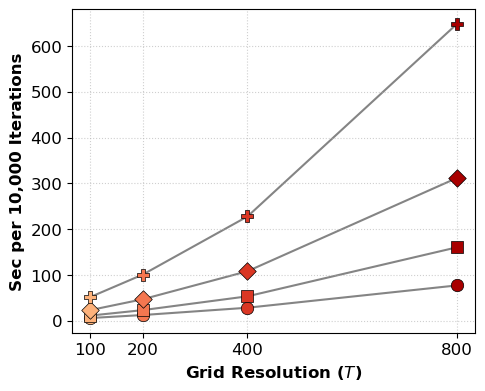

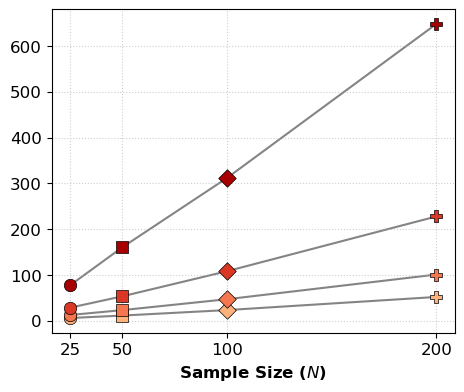

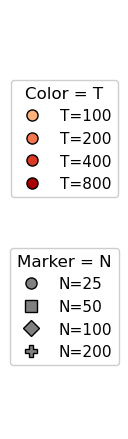

In [52]:
# --- Runtime plot (square grid only) from runtime_results.json ---
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

runtime_path = Path("fig/section2_4_1_st_v3/runtime_results.json")
if not runtime_path.exists():
    raise FileNotFoundError(f"Missing {runtime_path}. Run runtime scaling cell first.")

rows = json.loads(runtime_path.read_text())
if not isinstance(rows, list):
    raise TypeError("runtime_results.json must be a list of dicts.")

grid_obs = [25, 50, 100, 200]
grid_pts = [100, 200, 400, 800]

def _get_metric(r, K_runtime=10000, burn_iter=2000):
    if "sec_per_10000" in r:
        return float(r["sec_per_10000"])
    if "sec_per_iter" in r:
        return float(r["sec_per_iter"]) * 10000.0
    if "elapsed_sec" in r:
        denom = K_runtime * (1.0 - (burn_iter / float(K_runtime)))
        return (float(r["elapsed_sec"]) / denom) * 10000.0
    return float("nan")

pair_map = {}
for r in rows:
    if not isinstance(r, dict):
        continue
    if "num_obs" not in r or "num_points" not in r:
        continue
    try:
        key = (int(r["num_obs"]), int(r["num_points"]))
    except Exception:
        continue
    pair_map[key] = r

missing = []
for n in grid_obs:
    for t in grid_pts:
        if (n, t) not in pair_map:
            missing.append((n, t))
if missing:
    print("Missing grid entries:", missing)

# Build data_vs_T and data_vs_N
T_vals_arr = np.array(grid_pts)
N_lines_list = grid_obs
N_vals_arr = np.array(grid_obs)
T_lines_list = grid_pts

data_vs_T = {n: [] for n in N_lines_list}
data_vs_N = {t: [] for t in T_lines_list}
for n in N_lines_list:
    for t in T_lines_list:
        r = pair_map.get((n, t))
        data_vs_T[n].append(_get_metric(r) if r is not None else np.nan)
for t in T_lines_list:
    for n in N_lines_list:
        r = pair_map.get((n, t))
        data_vs_N[t].append(_get_metric(r) if r is not None else np.nan)

# --- (2) CSDA 스타일 설정 (Color & Marker) ---
colors_T_map = cm.OrRd(np.linspace(0.4, 0.9, len(T_lines_list)))
markers_N_map = ['o', 's', 'D', 'P']
line_color_gray = '#666666'

# --- (3) Figure A: Runtime vs. T (X=T) ---
fig_a, ax_left = plt.subplots(figsize=(5.2, 4.2))
for i_n, n in enumerate(N_lines_list):
    y_values = data_vs_T[n]
    ax_left.plot(T_vals_arr, y_values, color=line_color_gray,
                 linewidth=1.5, alpha=0.8, zorder=1)
    for i_t, t in enumerate(T_vals_arr):
        ax_left.scatter(t, y_values[i_t],
                        color=colors_T_map[i_t],
                        marker=markers_N_map[i_n],
                        s=80, zorder=2, edgecolors='k', linewidth=0.5)

ax_left.set_xlabel(r'Grid Resolution ($T$)', fontsize=12, fontweight='bold')
ax_left.set_ylabel('Sec per 10,000 Iterations', fontsize=12, fontweight='bold')
ax_left.grid(True, linestyle=':', alpha=0.6)
ax_left.set_xticks(T_vals_arr)
ax_left.tick_params(axis='both', labelsize=12)

fig_a.savefig('fig_scalability_csda_final_T.pdf', dpi=300, bbox_inches='tight')
plt.show()

# --- (4) Figure B: Runtime vs. N (X=N) ---
fig_b, ax_right = plt.subplots(figsize=(5.2, 4.2))
for i_t, t in enumerate(T_lines_list):
    y_values = data_vs_N[t]
    ax_right.plot(N_vals_arr, y_values, color=line_color_gray,
                  linewidth=1.5, alpha=0.8, zorder=1)
    for i_n, n in enumerate(N_vals_arr):
        ax_right.scatter(n, y_values[i_n],
                         color=colors_T_map[i_t],
                         marker=markers_N_map[i_n],
                         s=80, zorder=2, edgecolors='k', linewidth=0.5)

ax_right.set_xlabel(r'Sample Size ($N$)', fontsize=12, fontweight='bold')
ax_right.grid(True, linestyle=':', alpha=0.6)
ax_right.set_xticks(N_vals_arr)
ax_right.tick_params(axis='both', labelsize=12)

fig_b.savefig('fig_scalability_csda_final_N.pdf', dpi=300, bbox_inches='tight')
plt.show()

# --- Legend-only figure (for paper) ---
fig_leg, ax_leg = plt.subplots(figsize=(1, 4.2))
ax_leg.axis('off')
fig_leg.subplots_adjust(left=0, right=1, top=1, bottom=0)

legend_elements_color = [
    Line2D([0], [0], marker='o', color='w', label=f'T={t}',
           markerfacecolor=c, markersize=8, markeredgecolor='k')
    for t, c in zip(T_lines_list, colors_T_map)
]
legend_elements_marker = [
    Line2D([0], [0], marker=m, color='w', label=f'N={n}',
           markerfacecolor='gray', markersize=8, markeredgecolor='k')
    for n, m in zip(N_lines_list, markers_N_map)
]

leg1 = ax_leg.legend(handles=legend_elements_color, title='Color = T',
                loc='upper center', bbox_to_anchor=(0.5, 0.85),
                frameon=True, framealpha=0.95, fontsize=11, title_fontsize=12)
ax_leg.add_artist(leg1)

ax_leg.legend(handles=legend_elements_marker, title='Marker = N',
          loc='upper center', bbox_to_anchor=(0.5, 0.45),
          
          frameon=True, framealpha=0.95, fontsize=11, title_fontsize=12)

fig_leg.tight_layout(pad=0)
fig_leg.savefig('fig_legend.pdf', dpi=300, bbox_inches='tight')

plt.show()


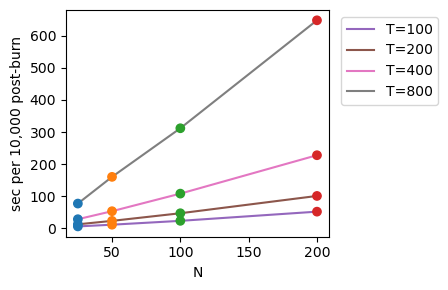

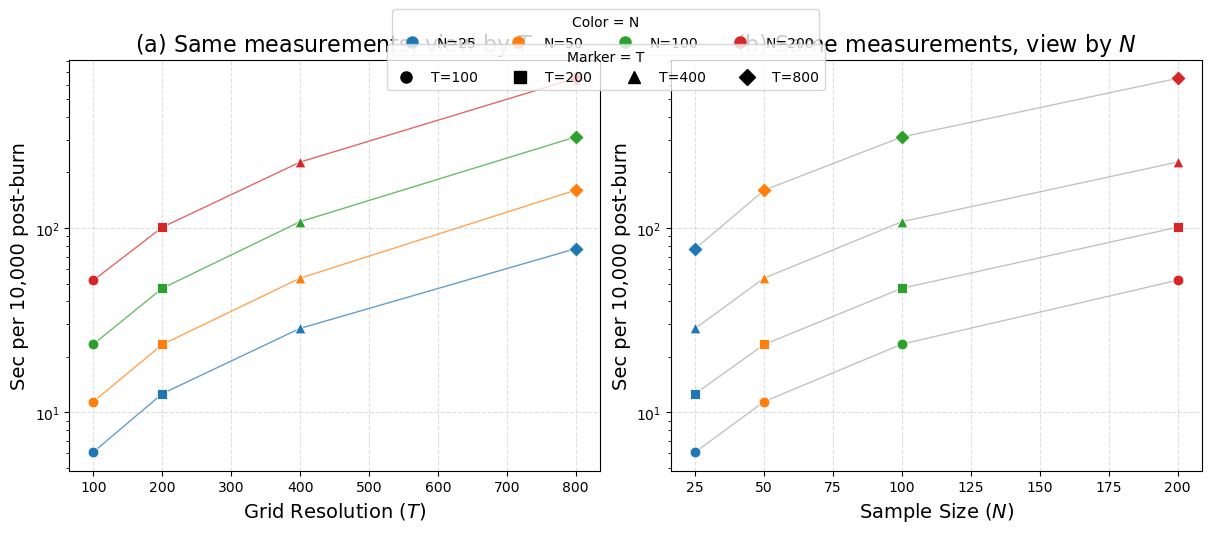

In [17]:
# --- Runtime plots (square grid only) from runtime_results.json ---
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

runtime_path = Path("fig/section2_4_1_st_v3/runtime_results.json")
if not runtime_path.exists():
    raise FileNotFoundError(f"Missing {runtime_path}. Run runtime scaling cell first.")

rows = json.loads(runtime_path.read_text())
if not isinstance(rows, list):
    raise TypeError("runtime_results.json must be a list of dicts.")

grid_obs = [25, 50, 100, 200]
grid_pts = [100, 200, 400, 800]

def _get_metric(r, K_runtime=10000, burn_iter=2000):
    if "sec_per_10000" in r:
        return float(r["sec_per_10000"])
    if "sec_per_iter" in r:
        return float(r["sec_per_iter"]) * 10000.0
    if "elapsed_sec" in r:
        denom = K_runtime * (1.0 - (burn_iter / float(K_runtime)))
        return (float(r["elapsed_sec"]) / denom) * 10000.0
    return float("nan")

pair_map = {}
for r in rows:
    if not isinstance(r, dict):
        continue
    if "num_obs" not in r or "num_points" not in r:
        continue
    try:
        key = (int(r["num_obs"]), int(r["num_points"]))
    except Exception:
        continue
    pair_map[key] = r

rows_grid = []
missing = []
for n in grid_obs:
    for t in grid_pts:
        r = pair_map.get((n, t))
        if r is None:
            missing.append((n, t))
        else:
            rows_grid.append({
                'N': n,
                'T': t,
                'sec': _get_metric(r),
            })
if missing:
    print("Missing grid entries:", missing)

df = pd.DataFrame(rows_grid)

Ns = grid_obs
Ts = grid_pts

# 색: N, 마커: T (explicit, paper style)
color_map = {25: 'C0', 50: 'C1', 100: 'C2', 200: 'C3'}
marker_map = {100: 'o', 200: 's', 400: '^', 800: 'D'}

use_logy = False  # set True for log-scale y

# ---------- Plot A: view by T ----------
fig, ax = plt.subplots(figsize=(7.2, 4.6))
for N in Ns:
    sub = df[df['N'] == N].sort_values('T')
    ax.plot(sub['T'], sub['sec'], color=color_map[N], alpha=0.5, linewidth=1.0)
    for _, r in sub.iterrows():
        ax.scatter(r['T'], r['sec'],
                   color=color_map[N],
                   marker=marker_map[r['T']],
                   s=80, edgecolor='white', linewidth=0.8, zorder=3)
ax.set_xlabel('Grid Resolution (T)')
ax.set_ylabel('Sec per 10,000 post-burn')
ax.grid(True, alpha=0.25)
if use_logy:
    ax.set_yscale('log')

handles_color = [plt.Line2D([0],[0], marker='o', linestyle='',
                            color=color_map[N], label=f'N={N}', markersize=8)
                 for N in Ns]
handles_marker = [plt.Line2D([0],[0], marker=marker_map[T], linestyle='',
                             color='black', label=f'T={T}', markersize=8)
                  for T in Ts]
fig.legend(handles=handles_color, loc='lower center', ncol=4, frameon=False, title='Color = N')
fig.legend(handles=handles_marker, loc='lower center', ncol=4, frameon=False,
           title='Marker = T', bbox_to_anchor=(0.5, -0.08))
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

# ---------- Plot B: view by N ----------
fig, ax = plt.subplots(figsize=(7.2, 4.6))
for T in Ts:
    sub = df[df['T'] == T].sort_values('N')
    ax.plot(sub['N'], sub['sec'], color='0.7', linewidth=1.0, alpha=0.8, zorder=1)
for _, r in df.iterrows():
    ax.scatter(r['N'], r['sec'],
               color=color_map[r['N']],
               marker=marker_map[r['T']],
               s=80, edgecolor='white', linewidth=0.8, zorder=3)
ax.set_xlabel('Sample Size (N)')
ax.set_ylabel('Sec per 10,000 post-burn')
ax.grid(True, alpha=0.25)
if use_logy:
    ax.set_yscale('log')

fig.legend(handles=handles_color, loc='lower center', ncol=4, frameon=False, title='Color = N')
fig.legend(handles=handles_marker, loc='lower center', ncol=4, frameon=False,
           title='Marker = T', bbox_to_anchor=(0.5, -0.08))
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()
